<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Kozlov%20Alexey/InspectrumClinic_gr1_akozlov_20230626_08week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

Алексей Козлов 2023.06.26 - 2023.07.03 (8-я неделя): Подбор гиперпараметров, исследование возможностей использования новых датасетов

# ТЕХНИЧЕСКОЕ ЗАДАНИЕ

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

**Цель:**

Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.


**Принцип работы:**

1.   Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
2.   В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.
3.   Система может дополнять вердикт мнением, почему человек не годен, или почему ограниченно годен.


**Требования интерфейсу:**


*Минимальный уровень реализации:*

notebook google colaboratory. Требуется реализовать простой веб-интерфейс для загрузки анализируемого моделью нейросети набора данных и удобным выводом результатов вынесенного решения.

*Дополнительно:*

передача продвинутой системы веб-интерфейса, дополняющей вердикт мнением, почему человек не годен, или почему ограниченно годен.

**Требования к скорости работы:**

Не предъявляются

**Требования к тестированию, метрикам качества:**

Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.


# Импорт библиотек

In [301]:
# Загрузка файлов из облака
import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
#Для генерации случайных чисел
import random
# Для округления
import math
import re

# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import clear_output

# Для работы с датами
from datetime import datetime

#from keras import metrics

# Приказ Министерства здравоохранения Российской Федерации от 28.01.2021 №29Н

https://normativ.kontur.ru/document?moduleId=1&documentId=416520

"МИНИСТЕРСТВО ЗДРАВООХРАНЕНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ
ПРИКАЗ
от 28 января 2021 г. N 29н
ОБ УТВЕРЖДЕНИИ ПОРЯДКА ПРОВЕДЕНИЯ ОБЯЗАТЕЛЬНЫХ ПРЕДВАРИТЕЛЬНЫХ И ПЕРИОДИЧЕСКИХ МЕДИЦИНСКИХ ОСМОТРОВ РАБОТНИКОВ, ПРЕДУСМОТРЕННЫХ ЧАСТЬЮ ЧЕТВЕРТОЙ СТАТЬИ 213 ТРУДОВОГО КОДЕКСА РОССИЙСКОЙ ФЕДЕРАЦИИ, ПЕРЕЧНЯ МЕДИЦИНСКИХ ПРОТИВОПОКАЗАНИЙ К ОСУЩЕСТВЛЕНИЮ РАБОТ С ВРЕДНЫМИ И (ИЛИ) ОПАСНЫМИ ПРОИЗВОДСТВЕННЫМИ ФАКТОРАМИ, А ТАКЖЕ РАБОТАМ, ПРИ ВЫПОЛНЕНИИ КОТОРЫХ ПРОВОДЯТСЯ ОБЯЗАТЕЛЬНЫЕ ПРЕДВАРИТЕЛЬНЫЕ И ПЕРИОДИЧЕСКИЕ МЕДИЦИНСКИЕ ОСМОТРЫ"

"Приложение N 2
к приказу Министерства здравоохранения
Российской Федерации
от 28 января 2021 г. N 29н

ПЕРЕЧЕНЬ МЕДИЦИНСКИХ ПРОТИВОПОКАЗАНИЙ К РАБОТАМ С ВРЕДНЫМИ И (ИЛИ) ОПАСНЫМИ ПРОИЗВОДСТВЕННЫМИ ФАКТОРАМИ, А ТАКЖЕ РАБОТАМ, ПРИ ВЫПОЛНЕНИИ КОТОРЫХ ПРОВОДЯТСЯ ОБЯЗАТЕЛЬНЫЕ ПРЕДВАРИТЕЛЬНЫЕ И ПЕРИОДИЧЕСКИЕ МЕДИЦИНСКИЕ ОСМОТРЫ"

**Использую Приложение №2 для дополнения вердикта мнением, почему человек не годен, или почему ограниченно годен.**

## Словарь-датафрейм болезней

Поля в таблице Приложения 2:

- Наименование болезней, степень нарушения функции организма,
- Код по МКБ-10,
- Вредные и (или) опасные производственные факторы,
- Виды работ

Дополнительно таблица Приложения 2 поделена на 17 классов болезней, по числу которых трансформировал оригинальный документ в текстовые-csv файлы с разделителем '|'.

In [302]:
# Создаем списки-классификаторы, которые потом будем использовать для пояснения решения
class29_lst = list()
class29_lst.append("Класс I. Некоторые инфекционные и паразитарные болезни")
class29_lst.append("Класс II. Новообразования")
class29_lst.append("Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм")
class29_lst.append("Класс IV. Болезни эндокринной системы, расстройства питания, нарушения обмена веществ")
class29_lst.append("Класс V. Психические расстройства и расстройства поведения - по перечням и в порядке, утвержденным Правительством Российской Федерации")
class29_lst.append("Класс VI. Болезни нервной системы")
class29_lst.append("Класс VII. Болезни глаза и его придаточного аппарата")
class29_lst.append("Класс VIII. Болезни уха и сосцевидного отростка")
class29_lst.append("Класс IX. Болезни системы кровообращения")
class29_lst.append("Класс X. Болезни органов дыхания")
class29_lst.append("Класс XI. Болезни органов пищеварения")
class29_lst.append("Класс XII. Болезни кожи и подкожной клетчатки")
class29_lst.append("Класс XIII. Болезни костно-мышечной системы и соединительной ткани")
class29_lst.append("Класс XIV. Болезни мочеполовой системы")
class29_lst.append("Класс XV. Беременность, роды и послеродовой период")
class29_lst.append("Класс XVII. Врожденные аномалии, деформации и хромосомные нарушения")
class29_lst.append("Класс XIX. Травмы, отравления и некоторые другие последствия воздействий внешних причин")

# Наименование болезней
diseases29_lst = list()

# Создаю датафрейм из приложения 2 приказа №29Н
df29 = pd.DataFrame(columns=['Класс', 'Болезнь', 'МКБ10', 'ВредФакторы', 'ВидыРабот'])
df29['Класс'] = df29['Класс'].astype(int)
df29['Болезнь'] = df29['Болезнь'].astype(int)
df29['МКБ10'] = df29['МКБ10'].astype(str)
df29['ВредФакторы'] = df29['ВредФакторы'].astype(str)
df29['ВидыРабот'] = df29['ВидыРабот'].astype(str)

## Загрузка 17 текстовых файлов классов болезней

Подключаю гуугл-диск, на который предварительно скопировал zip-архив, в которых 17 текстовых файлов.

In [303]:
# from google.colab import drive
# drive.mount('/content/drive')

In [304]:
# dir_name_29 = '/content/drive/MyDrive/akozlov_traineeship1/mkb10_disease/'

In [305]:
# import os.path

# fn_29 = dir_name_29 + 'prikazN29H_2-1.txt'
# # print(f'fn_29: {fn_29}')

# if not os.path.exists(fn_29):
#   # разворачиваем архив
#   !unzip -q /content/drive/MyDrive/akozlov_traineeship1/mkb10_disease.zip -d /content/drive/MyDrive/akozlov_traineeship1

# # смотрим список файлов
# !ls /content/drive/MyDrive/akozlov_traineeship1/mkb10_disease

Для того чтобы постоянно не подтверждать скачивание файла с гуугл-диска, делаю скачивание по общедоступной ссылке:

In [306]:
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=180prezoaEESrwOpYu7PgOHjytbZ4AceL', None, quiet=True)

'mkb10_disease.zip'

In [307]:
dir_name_29 = '/content/mkb10_disease'

In [308]:
import os.path

# /content/mkb10_disease/prikazN29H_2-1.txt
fn_29 = dir_name_29 + '/prikazN29H_2-1.txt'
# print(f'fn_29: {fn_29}')

# разворачиваем архив, если он не развернут
if not os.path.exists(fn_29):
  !unzip -q mkb10_disease.zip

# смотрим список файлов
!ls '/content/mkb10_disease'

prikazN29H_2-10.txt  prikazN29H_2-17.txt  prikazN29H_2-5.txt
prikazN29H_2-11.txt  prikazN29H_2-19.txt  prikazN29H_2-6.txt
prikazN29H_2-12.txt  prikazN29H_2-1.txt   prikazN29H_2-7.txt
prikazN29H_2-13.txt  prikazN29H_2-2.txt   prikazN29H_2-8.txt
prikazN29H_2-14.txt  prikazN29H_2-3.txt   prikazN29H_2-9.txt
prikazN29H_2-15.txt  prikazN29H_2-4.txt


## Обработка 17 текстовых файлов классов болезней

In [309]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Код по МКБ-10` из приказа 29 по запятым и минусам
#~~~~~~~~~~~~~~~~~~~~~~~~
def mkb29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'mkb29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      # print(f' str_lst1>: {len(str_lst1)}: {str_lst1}')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          # print(f' str_item2: {str_item2}')
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            # print(f'  str_item31: `{str_item31}`')
            # print(f'  str_item32: `{str_item32}`')
            last_dot_index31 = str_item31.rfind('.')
            last_dot_index32 = str_item32.rfind('.')
            if last_dot_index31 >= 0 or last_dot_index32 >= 0:
              str41 = str_item31
              str42 = ""
              if last_dot_index31 >= 0:
                str41, str42 = str_item31[:last_dot_index31], str_item31[last_dot_index31+1:]
              #~
              str51 = str_item32
              str52 = ""
              if last_dot_index32 >= 0:
                str51, str52 = str_item32[:last_dot_index32], str_item32[last_dot_index32+1:]
              #~
              jnum42 = 0
              jnum52 = 0
              # проверяем, что строка не пустая
              if str42:
                jnum42 = int(str42)
              if str52:
                jnum52 = int(str52)
              #~
              # print(f'str41: `{str41}`, str42: `{str42}`, jnum42: `{jnum42}`')
              # print(f'str51: `{str51}`, str52: `{str52}`, jnum52: `{jnum52}`')
              for j in range(jnum42, jnum52+1):
                if (jnum42 == j):
                  retVal.append(str_item31)
                elif (jnum52+1 == j):
                  retVal.append(str_item32)
                else:
                  retVal.append(str41 + '.' + str(j))
            else:
              str_item40 = str_item31[:1]
              str_item41 = str_item31[1:]
              str_item42 = str_item32[1:]
              num41 = int(str_item41)
              num42 = int(str_item42)
              # print(f'  str_item40: `{str_item40}`, str_item41: `{str_item41}`, str_item42: `{str_item42}`')
              # print(f'  num41: `{num41}`, num42: `{num42}`')
              for i in range(num41, num42+1):
                if i < 10:
                  retVal.append(str_item40 + '0' + str(i))
                else:
                  retVal.append(str_item40 + str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  # print(f'    retVal: {retVal}')
  return retVal

In [310]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Вредные и (или) опасные производственные факторы` из приказа 29 по запятым и минусам
# Harmful Factors
#~~~~~~~~~~~~~~~~~~~~~~~~
def hf29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'hf29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            if str_item31.find('.') >= 0:
              last_dot_index31 = str_item31.rfind('.')
              str41, str42 = str_item31[:last_dot_index31], str_item31[last_dot_index31+1:]
              # print(f'str41: {str41}')
              # print(f'str42: {str42}')
              last_dot_index32 = str_item32.rfind('.')
              str51, str52 = str_item32[:last_dot_index32], str_item32[last_dot_index32+1:]
              # print(f'str51: {str51}')
              # print(f'str52: {str52}')
              jnum42 = int(str42)
              jnum52 = int(str52)
              # print(f'jnum42: {jnum42} - jnum52: {jnum52}')
              for j in range(jnum42, jnum52+1):
                retVal.append(str41 + '.' + str(j))
              # print(f'retVal: {retVal}')
            else:
              num31 = int(str_item31)
              num32 = int(str_item32)
              for i in range(num31, num32+1):
                retVal.append(str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  return retVal

In [311]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Виды работ` из приказа 29 по запятым и минусам
# Types of work
#~~~~~~~~~~~~~~~~~~~~~~~~
def tow29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            num31 = int(str_item31)
            num32 = int(str_item32)
            for i in range(num31, num32+1):
              retVal.append(str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  return retVal

In [312]:
def addClassToAccumulator29(file_name29, class29_inx, df_29):
  '''
    Чтение текстового файла и добавление его значений по спискам
    вход:
        file_name29: имя текстового файла
        class29_inx: индекс класса в списке class29_lst0
    выход:
        df_29: дополненный дата фрейм
  '''
  # print()
  # print('-'*50)
  # print(f'{file_name29}')
  # print(f'class29_inx: {class29_inx}')

  # чтение файла и создание списка строк
  # with open('/content/'+file_name29, 'r') as file29:
  with open(file_name29, 'r') as file29:
    lines29 = file29.readlines()

  # print(f'{len(lines29)}: {lines29}')

  for i in range(len(lines29)):
    # print(f'{i}->{len(lines29)}: {lines29[i]}')
    str1 = lines29[i].strip()
    # разбиваем строку по вертикальным линиям
    str_lst1 = str1.split('|')
    if 4 == len(str_lst1):
      # 0: `а) Активный туберкулез.... `
      # 1: `A15 - A19`
      # 2: `1 - 5`
      # 3: `6 - 27`
      #~~~0 ~ Наименование болезней
      diseases29_lst.append(str_lst1[0].strip())
      diseases29_inx = len(diseases29_lst) - 1
      # print(f'diseases29_inx: {diseases29_inx}, len(diseases29): {len(diseases29)}, {diseases29}')
      #~~~1 ~ МКБ-10
      mkb29_lst = mkb29_split(str_lst1[1].strip())
      if len(mkb29_lst) < 1:
        print(f'ОШИБКА: неверное значение МКБ: {file_name29}')
        continue
      # print(f'mkb29_lst: `{mkb29_lst}`')
      #~~~2 ~ Вредные факторы
      hf29_lst = hf29_split(str_lst1[2].strip())
      hf29_str = ""
      if len(hf29_lst) > 0:
        hf29_str = ','.join(hf29_lst)
      # print(f'hf29_lst: `{hf29_lst}`')
      # print(f'hf29_str: `{hf29_str}`')
      #~~~3 ~ Виды работ
      tow29_lst = tow29_split(str_lst1[3].strip())
      tow29_str = ""
      if len(tow29_lst) > 0:
        tow29_str = ','.join(tow29_lst)
      # print(f'tow29_lst: `{tow29_lst}`')
      # print(f'tow29_str: `{tow29_str}`')
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~~~~добавляю сформированне строки в датафрейм
      for j in range(len(mkb29_lst)):
        # print(f'{j}: {mkb29_lst[j]}')
        newrow_29 = {'Класс': class29_inx, 'Болезнь': diseases29_inx, 'МКБ10': mkb29_lst[j], 'ВредФакторы': hf29_str, 'ВидыРабот': tow29_str}
        df_29 = pd.concat([df_29, pd.DataFrame(newrow_29, index=[0])], ignore_index=True)
    else:
      print(f'ОШИБКА: неверное число данных в колонках: {file_name29}')

  return df_29

In [313]:
# Формирую-создаю датафрейм из приложения 2 приказа №29Н
print(f'число классов: {len(class29_lst)}')
for i in range(len(class29_lst)):
  print()
  print('-'*50)
  print(f'{i}: {class29_lst[i]}')
  j = i + 1
  if 15 == i:
    j = 17
  elif 16 == i:
    j = 19
  #~~~
  fn_29 = dir_name_29 + '/prikazN29H_2-' + str(j) + '.txt'
  print(f'fn_29: `{fn_29}`')
  #~~~
  df29 = addClassToAccumulator29(fn_29, i, df29);
  print(f'размеры датафрейма: df29: {df29.shape}')
  print(df29.tail(2))

число классов: 17

--------------------------------------------------
0: Класс I. Некоторые инфекционные и паразитарные болезни
fn_29: `/content/mkb10_disease/prikazN29H_2-1.txt`
размеры датафрейма: df29: (74, 5)
    Класс  Болезнь МКБ10 ВредФакторы       ВидыРабот
72      0        6   B82              23,24,25,26,27
73      0        6   B83              23,24,25,26,27

--------------------------------------------------
1: Класс II. Новообразования
fn_29: `/content/mkb10_disease/prikazN29H_2-2.txt`
размеры датафрейма: df29: (371, 5)
     Класс  Болезнь МКБ10 ВредФакторы ВидыРабот
369      1       14   D35           Р          
370      1       14   D36           Р          

--------------------------------------------------
2: Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм
fn_29: `/content/mkb10_disease/prikazN29H_2-3.txt`
размеры датафрейма: df29: (571, 5)
     Класс  Болезнь МКБ10                                        ВредФакторы

## Пример работы с df29

In [314]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Пример получения информации по коду МКБ-10
#~~~~~~~~~~~~~~~~~~~~~~~~

mkb_10 = 'A16'

inxs29 = df29.index[df29['МКБ10'] == mkb_10].tolist()
print(f'{len(inxs29)}: {inxs29}')

for i in range(len(inxs29)):
  print()
  print('='*50)
  print(f'{i}->{len(inxs29)-1}')
  elems29 = df29.iloc[inxs29[i]].values
  print(f'{len(elems29)}: {elems29}')
  #~Класс
  print('-'*50)
  print('Класс:')
  ielem = int(elems29[0])
  print(f'  {ielem}: {class29_lst[ielem]}')
  #~Болезнь
  print('-'*50)
  print('Наименование болезней, степень нарушения функции организма:')
  ielem = int(elems29[1])
  print(f'  {ielem}: {diseases29_lst[ielem]}')
  #~МКБ10
  print('-'*50)
  print('Код по МКБ-10:')
  print(f'  {elems29[2]}')
  #~ВредФакторы
  print('-'*50)
  print('Вредные и (или) опасные производственные факторы:')
  print(f'  {elems29[3]}')
  #~ВидыРабот
  print('-'*50)
  print('Виды работ :')
  print(f'  {elems29[4]}')

2: [11, 16]

0->1
5: [0 1 'A16' '' '']
--------------------------------------------------
Класс:
  0: Класс I. Некоторые инфекционные и паразитарные болезни
--------------------------------------------------
Наименование болезней, степень нарушения функции организма:
  1: Туберкулез органов дыхания, других органов и систем:
--------------------------------------------------
Код по МКБ-10:
  A16
--------------------------------------------------
Вредные и (или) опасные производственные факторы:
  
--------------------------------------------------
Виды работ :
  

1->1
5: [0 2 'A16' '1,2,3,4,5'
 '6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27']
--------------------------------------------------
Класс:
  0: Класс I. Некоторые инфекционные и паразитарные болезни
--------------------------------------------------
Наименование болезней, степень нарушения функции организма:
  2: а) Активный туберкулез органов дыхания; последствия хирургического лечения или выраженные остаточны

# Загрузка датасета, отображение сводной информации

In [315]:
# Загрузка файла датасета от 2023.05.08
# url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx'

# Загрузка файла датасета от 2023.06.26
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/26.06%20new%20dataset.zip'

#Inspectrum-Clinic-Dataset
url2 = '/content/ICD20230626.zip'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/26.06%20new%20dataset.zip
To: /content/ICD20230626.zip
100%|██████████| 6.97M/6.97M [00:01<00:00, 5.67MB/s]


'/content/ICD20230626.zip'

In [316]:
dir_dataset2606 = '/content/26.06 new dataset'

In [317]:
# /content/26.06 new dataset/neiro-08-22.csv
fn2606_1 = dir_dataset2606 + '/neiro-08-22.csv'
# print(f'fn2606_1: {fn2606_1}')

# разворачиваем архив, если он не развернут
if not os.path.exists(fn2606_1):
  !unzip -q ICD20230626.zip

# смотрим список файлов
!ls '/content/26.06 new dataset'

 neiro_01-22.csv   neiro_03_23.csv   neiro_06-22.csv	    neiro-10-22.csv
 neiro_01_23.csv   neiro_04-22.csv   neiro_06-23.csv	    neiro_12-22.csv
 neiro_02-22.csv   neiro_04_23.csv   neiro_07-22.csv
 neiro_02_23.csv   neiro_05-22.csv   neiro-08-22.csv
 neiro_03-22.csv   neiro_05_23.csv  'neiro-09-22 (1).csv'


**Открываю в цикле последовательно все 17 csv-файлов и анализирую информацию по ним.**

In [318]:
files2606 = os.listdir(dir_dataset2606)
files2606.sort()
print(f'число файлов в архиве: {len(files2606)}')
print(f'{files2606}')

for i in range(len(files2606)):
  df17_fn = dir_dataset2606 + '/' + files2606[i]
  print()
  print('='*50)
  print(f'{i}->{len(files2606)}: {df17_fn}')
  #~~~ читаем очередной датафрейм
  #~в файле 'neiro-10-22.csv' в разных строках содержится разное количество колонок
  #~поэтому исключаю его из обработки
  # 2->17: /content/26.06 new dataset/neiro-10-22.csv
  if 2 == i: continue
  #~
  df17 = pd.read_csv(df17_fn, delimiter=';')
  #~~~ информация о прочитанном датафрейме
  df17.info()
  #~~~ отображаю названия колонок текущего датафрейма
  print('-'*25)
  col17_names = list(df17.columns)
  print(f'{len(col17_names)}: {col17_names}')
  #~~~ удаляем открытый текущий датафрейм из памяти
  del df17

число файлов в архиве: 17
['neiro-08-22.csv', 'neiro-09-22 (1).csv', 'neiro-10-22.csv', 'neiro_01-22.csv', 'neiro_01_23.csv', 'neiro_02-22.csv', 'neiro_02_23.csv', 'neiro_03-22.csv', 'neiro_03_23.csv', 'neiro_04-22.csv', 'neiro_04_23.csv', 'neiro_05-22.csv', 'neiro_05_23.csv', 'neiro_06-22.csv', 'neiro_06-23.csv', 'neiro_07-22.csv', 'neiro_12-22.csv']

0->17: /content/26.06 new dataset/neiro-08-22.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Columns: 304 entries, c81ca06c-f5ce-11ec-8102-0cc47aab8067 to Unnamed: 303
dtypes: bool(1), object(303)
memory usage: 4.0+ MB
-------------------------
304: ['c81ca06c-f5ce-11ec-8102-0cc47aab8067', '94fbc99b-f159-11ec-8102-0cc47aab8067', '1977-07-18T00:00:00', 'Мужской', 'Мужской.1', '2022-06-27T00:00:00', 'Периодический', 'Периодический.1', 'false', 'c8b811af-dcd2-11e8-80ce-0cc47aab8067', 'Unnamed: 10', 'Заместитель главного инженера', 'Годен', 'Годен к работе в указанных условиях', 'Годен к работе в указанных усло

<ipython-input-318-ddf35f90e93c>:17: DtypeWarning: Columns (10,11,12,13,14,22,23,24,25,26,27,32,33,34,35,36,37,38,39,40,41,42,43,50,51,52,53,54,55,80,81,82,83,84,85,88,89,96,97,98,99,108,109,110,111,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,166,167,168,169,170,171,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,206,207,208,209,214,215,218,219,220,221,222,223,224,225,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116 entries, 0 to 2115
Columns: 446 entries, 5f2149e5-334a-11e9-80ce-0cc47aab8067 to Unnamed: 445
dtypes: bool(1), object(445)
memory usage: 7.2+ MB
-------------------------
446: ['5f2149e5-334a-11e9-80ce-0cc47aab8067', 'bd882fc0-f2c9-11e8-80ce-0cc47aab8067', '1955-05-07T00:00:00', 'Мужской', 'Мужской.1', '2019-02-18T00:00:00', 'Периодический', 'Периодический.1', 'true', '6e4bb5f7-ee34-11e8-80ce-0cc47aab8067', 'Спортивная школа', 'Тренер', 'Годен', 'Годен к работе в указанных условиях', 'Годен к работе в указанных условиях.1', 'Unnamed: 15', 'c6c56e58-334b-11e9-80ce-0cc47aab8067', '2019-02-18T12:06:57', 'Z00.0', 'Общий медицинский осмотр', '[Z00.0] Общий медицинский осмотр\r\n', '[Z00.0] Общий медицинский осмотр\r\n.1', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed

<ipython-input-318-ddf35f90e93c>:17: DtypeWarning: Columns (54,80,81,82,83,84,85,98,99,100,101,102,103,106,107,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  df17 = pd.read_csv(df17_fn, delimiter=';')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Columns: 458 entries, d1245c91-b1d9-11ea-80dd-0cc47aab8067 to Unnamed: 457
dtypes: bool(1), object(457)
memory usage: 6.6+ MB
-------------------------
458: ['d1245c91-b1d9-11ea-80dd-0cc47aab8067', '4c1ff6c3-7a93-11e8-80ce-0cc47aab8067', '1988-06-06T00:00:00', 'Мужской', 'Мужской.1', '2020-06-19T00:00:00', 'Периодический', 'Периодический.1', 'false', '36ced484-5281-11e8-80cc-0cc47aab8067', 'Технический отдел', 'Монтажник', 'Годен', 'Годен к работе в указанных условиях', 'Годен к работе в указанных условиях.1', 'Unnamed: 15', '744c9880-b1db-11ea-80dd-0cc47aab8067', '2020-06-19T08:17:50', 'Z00.0', 'Общий медицинский осмотр', '[Z00.0] Общий медицинский осмотр\r\n', '[Z00.0] Общий медицинский осмотр\r\n.1', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Un

**Выводы:**

1. **Количество колонок и типы данных разные.**

2. **В файле 'neiro-10-22.csv' в разных строках содержится разное количество колонок, поэтому исключаю его из обработки.**

3. **Названия колонок есть только в файле 'neiro_06-23.csv'.**

4. **Совмещение таблиц с разным количеством колонок без названий скорее всего приведет к смешиванию данных по смыслу и в итоге к отрицательному результату. Крайне желательно объединять таблицы с подписанными колонками.**

## 'neiro_06-23.csv' - 14-ый файл - колонки подписаны

In [319]:
#14->17: /content/26.06 new dataset/neiro_06-23.csv
inx = 14
df17_fn = dir_dataset2606 + '/' + files2606[inx]
print(f'{inx}->{len(files2606)}: {df17_fn}')
df1 = pd.read_csv(df17_fn, delimiter=';')
print('='*50)
df1.info()
print('='*50)
print(f'df1 число строк: {df1.shape[0]}')
print(f'df1 число колонок: {df1.shape[1]}')
nan_cell_count = df1.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице df1: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')
print('='*50)
print('индекс - название - тип колонки:')
print('-'*50)
for j in range(df1.shape[1]):
  jcol = df1.columns[j]
  jcol_type = df1.dtypes[j]
  print(f'{j}->{df1.shape[1]}: {jcol} - {jcol_type}')

14->17: /content/26.06 new dataset/neiro_06-23.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Columns: 190 entries, ДокументПрохождениеМедосмотра to Хирургия2_Диагноз_ЗначениеПредставление
dtypes: bool(1), object(189)
memory usage: 1.5+ MB
df1 число строк: 1041
df1 число колонок: 190
общее количество пропусков во всей таблице df1: 136994, 69.26%
индекс - название - тип колонки:
--------------------------------------------------
0->190: ДокументПрохождениеМедосмотра - object
1->190: Клиент - object
2->190: КлиентДатаРождения - object
3->190: КлиентПол - object
4->190: КлиентПолПредставление - object
5->190: ДатаЗавершенияМедосмотра - object
6->190: ТипМедосмотра - object
7->190: ТипМедосмотраПредставление - object
8->190: ПсихОсвидетельствование - bool
9->190: Контрагент - object
10->190: Цех - object
11->190: Профессия - object
12->190: ЗаключениеМК - object
13->190: ЗаключениеМКПредставление - object
14->190: Заключение - object
15->190: ВредныеФакторы -

## Анализ первых 0..15 колонок в остальных 16-и файлах:

0 - ДокументПрохождениеМедосмотра

1 - Клиент

2 - КлиентДатаРождения

3 - КлиентПол

4 - КлиентПолПредставление

5 - ДатаЗавершенияМедосмотра

6 - ТипМедосмотра

7 - ТипМедосмотраПредставление

8 - ПсихОсвидетельствование

9 - Контрагент

10 - Цех

11 - Профессия

12 - ЗаключениеМК

13 - ЗаключениеМКПредставление

14 - Заключение

15 - ВредныеФакторы

In [320]:
for i in range(len(files2606)):
  df17_fn = dir_dataset2606 + '/' + files2606[i]
  print()
  print('='*50)
  print(f'файл: {i}->{len(files2606)}: {df17_fn}')
  #~~~ читаем очередной датафрейм
  #~
  #~в файле 'neiro-10-22.csv' в разных строках содержится разное количество колонок
  #~поэтому исключаю его из обработки
  # 2->17: /content/26.06 new dataset/neiro-10-22.csv
  if 2 == i: continue
  #~
  #~neiro_06-23.csv - также пропускаем из рассмотрения, потому что с ним сравниваем
  if 14 == i: continue
  #~
  #~~~~~~~~~~~~~~~~~~~~~~~~
  df17 = pd.read_csv(df17_fn, delimiter=';')
  #сравнение с файлом, в котором колонки подписаны - neiro_06-23.csv
  for j in range(16):
    # neiro_06-23.csv
    jcol = df1.columns[j]
    jcol_type = df1.dtypes[j]
    col_lst = df1.iloc[:, j].tolist()
    print(f'  neiro_06-23.csv: колонка {j}: {jcol} - {jcol_type} ({col_lst[0]})')
    # neiro-08-22.csv,.... - текущий файл, клонки не подписаны
    jcol = df17.columns[j]
    jcol_type = df17.dtypes[j]
    col_lst = df17.iloc[:, j].tolist()
    print(f'  {files2606[i]}: колонка {j}: {jcol} - {jcol_type} ({col_lst[1]})')
    print('-')
  #~~~ удаляем открытый текущий датафрейм из памяти
  del df17


файл: 0->17: /content/26.06 new dataset/neiro-08-22.csv
  neiro_06-23.csv: колонка 0: ДокументПрохождениеМедосмотра - object (8ad4616c-0b5b-11ee-8133-0cc47aab8067)
  neiro-08-22.csv: колонка 0: c81ca06c-f5ce-11ec-8102-0cc47aab8067 - object (8608fb59-f5d4-11ec-8102-0cc47aab8067)
-
  neiro_06-23.csv: колонка 1: Клиент - object (2264f308-b78c-11ea-80dd-0cc47aab8067)
  neiro-08-22.csv: колонка 1: 94fbc99b-f159-11ec-8102-0cc47aab8067 - object (94fbc9d1-f159-11ec-8102-0cc47aab8067)
-
  neiro_06-23.csv: колонка 2: КлиентДатаРождения - object (1980-08-29T00:00:00)
  neiro-08-22.csv: колонка 2: 1977-07-18T00:00:00 - object (1989-08-29T00:00:00)
-
  neiro_06-23.csv: колонка 3: КлиентПол - object (Мужской)
  neiro-08-22.csv: колонка 3: Мужской - object (Мужской)
-
  neiro_06-23.csv: колонка 4: КлиентПолПредставление - object (Мужской)
  neiro-08-22.csv: колонка 4: Мужской.1 - object (Мужской)
-
  neiro_06-23.csv: колонка 5: ДатаЗавершенияМедосмотра - object (2023-04-06T00:00:00)
  neiro-08-22.cs

<ipython-input-320-e8ee55320c8f>:17: DtypeWarning: Columns (10,11,12,13,14,22,23,24,25,26,27,32,33,34,35,36,37,38,39,40,41,42,43,50,51,52,53,54,55,80,81,82,83,84,85,88,89,96,97,98,99,108,109,110,111,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,166,167,168,169,170,171,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,206,207,208,209,214,215,218,219,220,221,222,223,224,225,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,3

  neiro_06-23.csv: колонка 0: ДокументПрохождениеМедосмотра - object (8ad4616c-0b5b-11ee-8133-0cc47aab8067)
  neiro_03-22.csv: колонка 0: 5f2149e5-334a-11e9-80ce-0cc47aab8067 - object (de719ca2-35aa-11e9-80ce-0cc47aab8067)
-
  neiro_06-23.csv: колонка 1: Клиент - object (2264f308-b78c-11ea-80dd-0cc47aab8067)
  neiro_03-22.csv: колонка 1: bd882fc0-f2c9-11e8-80ce-0cc47aab8067 - object (2c7a79f6-2df6-11e9-80ce-0cc47aab8067)
-
  neiro_06-23.csv: колонка 2: КлиентДатаРождения - object (1980-08-29T00:00:00)
  neiro_03-22.csv: колонка 2: 1955-05-07T00:00:00 - object (1969-12-17T00:00:00)
-
  neiro_06-23.csv: колонка 3: КлиентПол - object (Мужской)
  neiro_03-22.csv: колонка 3: Мужской - object (Мужской)
-
  neiro_06-23.csv: колонка 4: КлиентПолПредставление - object (Мужской)
  neiro_03-22.csv: колонка 4: Мужской.1 - object (Мужской)
-
  neiro_06-23.csv: колонка 5: ДатаЗавершенияМедосмотра - object (2023-04-06T00:00:00)
  neiro_03-22.csv: колонка 5: 2019-02-18T00:00:00 - object (2019-02-21T00

<ipython-input-320-e8ee55320c8f>:17: DtypeWarning: Columns (54,80,81,82,83,84,85,98,99,100,101,102,103,106,107,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  df17 = pd.read_csv(df17_fn, delimiter=';')


  neiro_06-23.csv: колонка 0: ДокументПрохождениеМедосмотра - object (8ad4616c-0b5b-11ee-8133-0cc47aab8067)
  neiro_05_23.csv: колонка 0: 7a6ea4a3-e278-11ed-812b-0cc47aab8067 - object (d98be836-d1d4-11ed-8124-0cc47aab8067)
-
  neiro_06-23.csv: колонка 1: Клиент - object (2264f308-b78c-11ea-80dd-0cc47aab8067)
  neiro_05_23.csv: колонка 1: 004fd33f-e04a-11ed-812a-0cc47aab8067 - object (3cbedda4-c958-11ed-8116-0cc47aab8067)
-
  neiro_06-23.csv: колонка 2: КлиентДатаРождения - object (1980-08-29T00:00:00)
  neiro_05_23.csv: колонка 2: 1989-10-27T00:00:00 - object (1983-11-29T00:00:00)
-
  neiro_06-23.csv: колонка 3: КлиентПол - object (Мужской)
  neiro_05_23.csv: колонка 3: Мужской - object (Мужской)
-
  neiro_06-23.csv: колонка 4: КлиентПолПредставление - object (Мужской)
  neiro_05_23.csv: колонка 4: Мужской.1 - object (Мужской)
-
  neiro_06-23.csv: колонка 5: ДатаЗавершенияМедосмотра - object (2023-04-06T00:00:00)
  neiro_05_23.csv: колонка 5: 2023-03-27T00:00:00 - object (2023-04-03T00

**Анализ первых 0..15 колонок показал, что они во всех файлах идентичны.**

## Создание датафрейма с выделенными колонками

In [321]:
# Оставляю в data frame df1 только необходимые колонки,
# которые будут использованы при обучении нейронной сети,
# остальные удаляю
#~~~~~~~~~~~~~~~~~~~~~~~~
# 2->190: КлиентДатаРождения - object
# 3->190: КлиентПол - object
# 5->190: ДатаЗавершенияМедосмотра - object
# 6->190: ТипМедосмотра - object
# 8->190: ПсихОсвидетельствование - bool
# 10->190: Цех - object
# 11->190: Профессия - object
# 12->190: ЗаключениеМК - object
# 15->190: ВредныеФакторы - object

#~~~~~~~~~~~~~~~~~~~~~~~~
#1-Гинекология
#~~~
# 46->190: Гинекология1_ДокументПрием - object
# 47->190: Гинекология1_ДатаПриема - object
#   48->190: Гинекология1_МКБ101 - object
#   49->190: Гинекология1_ДиагнозПредставление1 - object
#   50->190: Гинекология1_Диагноз_Значение - object
# 51->190: Гинекология1_Диагноз_ЗначениеПредставление - object
#~~~
# 144->190: Гинекология2_ДокументПрием - object
# 145->190: Гинекология2_ДатаПриема - object
#   146->190: Гинекология2_МКБ101 - object
#   147->190: Гинекология2_ДиагнозПредставление1 - object
#   148->190: Гинекология2_Диагноз_Значение - object
# 149->190: Гинекология2_Диагноз_ЗначениеПредставление - object

#~~~~~~~~~~~~~~~~~~~~~~~~
#2-Стоматолог,Офтальмолог и т.д.?

#~~~~~~~~~~~~~~~~~~~~~~~~
# nn - neural network
df_nn_lst = ['КлиентДатаРождения',
             'КлиентПол',
             'ДатаЗавершенияМедосмотра',
             'ТипМедосмотра',
             'ПсихОсвидетельствование',
             'Цех',
             'Профессия',
             'ЗаключениеМК',
             'ВредныеФакторы',
             'Гинекология1_МКБ101',
             'Гинекология1_ДиагнозПредставление1',
             'Гинекология1_Диагноз_Значение',
             'Гинекология2_МКБ101',
             'Гинекология2_ДиагнозПредставление1',
             'Гинекология2_Диагноз_Значение'
             ]


In [322]:
# Удаляем все колонки, которые не входят в df_nn_lst
df1 = df1.drop(columns=[col for col in df1.columns if col not in df_nn_lst])
del df_nn_lst
df1.head(3)

,КлиентДатаРождения,КлиентПол,ДатаЗавершенияМедосмотра,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,Гинекология1_МКБ101,Гинекология1_ДиагнозПредставление1,Гинекология1_Диагноз_Значение,Гинекология2_МКБ101,Гинекология2_ДиагнозПредставление1,Гинекология2_Диагноз_Значение
0,1980-08-29T00:00:00,Мужской,2023-04-06T00:00:00,Периодический,False,NaN,Водитель-экспедитор,Годен,"18.2,23,4.3.2,5.1,1.50",NaN,NaN,NaN,NaN,NaN,NaN
1,1988-02-12T00:00:00,Мужской,2023-04-06T00:00:00,Периодический,False,NaN,Водитель автомобиля,Годен,"23,18.2,4.3.2,5.1,1.50",NaN,NaN,NaN,NaN,NaN,NaN
2,1980-08-26T00:00:00,Мужской,2023-04-06T00:00:00,Периодический,False,NaN,Водитель автомобиля,Годен,"23,18.2,4.3.2,5.1,1.50",NaN,NaN,NaN,NaN,NaN,NaN


## 'neiro-08-22.csv' - 0-ой файл - колонки не подписаны

In [323]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Поиск в таблице `neiro-08-22.csv` колонки `Гинекология1_ДиагнозПредставление1`
#~~~~~~~~~~~~~~~~~~~~~~~~
# for i in range(len(files2606)):
#   df17_fn = dir_dataset2606 + '/' + files2606[i]
#   print(f'файл: {i}->{len(files2606)}: {df17_fn}')
#   if 2 == i: continue
#   if 14 == i: continue
#~~~~~~~~~~~~~~~~~~~~~~~~

# файл: 0->17: /content/26.06 new dataset/neiro-08-22.csv
inx = 0
df17_fn = dir_dataset2606 + '/' + files2606[inx]
print(f'файл: {df17_fn}')
df17 = pd.read_csv(df17_fn, delimiter=';')
print(f'размеры датафрейма: df1: {df1.shape}, df17: {df17.shape}')

df17.head(3)

файл: /content/26.06 new dataset/neiro-08-22.csv
размеры датафрейма: df1: (1041, 15), df17: (1727, 304)


,c81ca06c-f5ce-11ec-8102-0cc47aab8067,94fbc99b-f159-11ec-8102-0cc47aab8067,1977-07-18T00:00:00,Мужской,Мужской.1,2022-06-27T00:00:00,Периодический,Периодический.1,false,c8b811af-dcd2-11e8-80ce-0cc47aab8067,...,Unnamed: 294,Unnamed: 295,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 300,Unnamed: 301,Unnamed: 302,Unnamed: 303
0,d9356d61-f5d4-11ec-8102-0cc47aab8067,94fbc9b7-f159-11ec-8102-0cc47aab8067,1970-01-04T00:00:00,Женский,Женский,2022-06-27T00:00:00,Периодический,Периодический,False,c8b811af-dcd2-11e8-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8608fb59-f5d4-11ec-8102-0cc47aab8067,94fbc9d1-f159-11ec-8102-0cc47aab8067,1989-08-29T00:00:00,Мужской,Мужской,2022-06-27T00:00:00,Периодический,Периодический,False,c8b811af-dcd2-11e8-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48373502-f6a0-11ec-8102-0cc47aab8067,94fbc9d5-f159-11ec-8102-0cc47aab8067,1977-05-25T00:00:00,Мужской,Мужской,2022-06-28T00:00:00,Периодический,Периодический,False,c8b811af-dcd2-11e8-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [324]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Гинекология
#~~~~~~~~~~~~~~~~~~~~~~~~
# #   48->190: Гинекология1_МКБ101 - object
# #   49->190: Гинекология1_ДиагнозПредставление1 - object
# #   50->190: Гинекология1_Диагноз_Значение - object
# # col_inx = df1.columns.get_loc('Гинекология1_МКБ101') #df1: 17->249: `N84.1`
# col_inx = df1.columns.get_loc('Гинекология1_ДиагнозПредставление1') #df1: 17->249: `Полип шейки матки`
# # col_inx = df1.columns.get_loc('Гинекология1_Диагноз_Значение') #df1: 17->249: `[N84.1] Полип шейки матки\r\n`
# print(f'df1: col_inx: {col_inx}')
# col_lst = df1.iloc[:, col_inx].tolist()
# for i in range(len(col_lst)):
#   print(f'df1: {i}->{len(col_lst)}: `{col_lst[i]}`')

# df1: 17->249: `Полип шейки матки`
# df1: 169->249: `Сальпингит и оофорит неуточненные`
# df1: 111->249: `Лейомиома матки неуточненная`

In [325]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Гинекология
#~~~~~~~~~~~~~~~~~~~~~~~~
# df1 оригинальный файл до удаления колонок
#~~~~~~~~~~~~~~~~~~~~~~~~
# 2->190: КлиентДатаРождения - object
# 3->190: КлиентПол - object
# 5->190: ДатаЗавершенияМедосмотра - object
# 6->190: ТипМедосмотра - object
# 8->190: ПсихОсвидетельствование - bool
# 10->190: Цех - object
# 11->190: Профессия - object
# 12->190: ЗаключениеМК - object
# 15->190: ВредныеФакторы - object
#~~~~~~~~~~~~~~~~~~~~~~~~
# df1 после удаления колонок
#~~~~~~~~~~~~~~~~~~~~~~~~
# 0->15(2): КлиентДатаРождения - object
# 1->15(3): КлиентПол - object
# 2->15(5): ДатаЗавершенияМедосмотра - object
# 3->15(6): ТипМедосмотра - object
# 4->15(8): ПсихОсвидетельствование - bool
# 5->15(10): Цех - object
# 6->15(11): Профессия - object
# 7->15(12): ЗаключениеМК - object
# 8->15(15): ВредныеФакторы - object
# 9->15: Гинекология1_МКБ101 - object
# 10->15: Гинекология1_ДиагнозПредставление1 - object
# 11->15: Гинекология1_Диагноз_Значение - object
# 12->15: Гинекология2_МКБ101 - object
# 13->15: Гинекология2_ДиагнозПредставление1 - object
# 14->15: Гинекология2_Диагноз_Значение - object
#~~~~~~~~~~~~~~~~~~~~~~~~
for j in range(df1.shape[1]):
  jcol = df1.columns[j]
  jcol_type = df1.dtypes[j]
  print(f'{j}->{df1.shape[1]}: {jcol} - {jcol_type}')

0->15: КлиентДатаРождения - object
1->15: КлиентПол - object
2->15: ДатаЗавершенияМедосмотра - object
3->15: ТипМедосмотра - object
4->15: ПсихОсвидетельствование - bool
5->15: Цех - object
6->15: Профессия - object
7->15: ЗаключениеМК - object
8->15: ВредныеФакторы - object
9->15: Гинекология1_МКБ101 - object
10->15: Гинекология1_ДиагнозПредставление1 - object
11->15: Гинекология1_Диагноз_Значение - object
12->15: Гинекология2_МКБ101 - object
13->15: Гинекология2_ДиагнозПредставление1 - object
14->15: Гинекология2_Диагноз_Значение - object


In [326]:
# Создаю новый пустой датафрейм df17_1
# 0->15(2): КлиентДатаРождения - object
# 1->15(3): КлиентПол - object
# 2->15(5): ДатаЗавершенияМедосмотра - object
# 3->15(6): ТипМедосмотра - object
# 4->15(8): ПсихОсвидетельствование - bool
# 5->15(10): Цех - object
# 6->15(11): Профессия - object
# 7->15(12): ЗаключениеМК - object
# 8->15(15): ВредныеФакторы - object
# 9->15: Гинекология1_МКБ101 - object
# 10->15: Гинекология1_ДиагнозПредставление1 - object
# 11->15: Гинекология1_Диагноз_Значение - object
# 12->15: Гинекология2_МКБ101 - object
# 13->15: Гинекология2_ДиагнозПредставление1 - object
# 14->15: Гинекология2_Диагноз_Значение - object

df17_1 = pd.DataFrame(columns=['КлиентДатаРождения',
                               'КлиентПол',
                               'ДатаЗавершенияМедосмотра',
                               'ТипМедосмотра',
                               'ПсихОсвидетельствование',
                               'Цех',
                               'Профессия',
                               'ЗаключениеМК',
                               'ВредныеФакторы',
                               'Гинекология1_МКБ101',
                               'Гинекология1_ДиагнозПредставление1',
                               'Гинекология1_Диагноз_Значение',
                               'Гинекология2_МКБ101',
                               'Гинекология2_ДиагнозПредставление1',
                               'Гинекология2_Диагноз_Значение'
                               ])

df17_1['КлиентДатаРождения'] = df17_1['КлиентДатаРождения'].astype(object)
df17_1['КлиентПол'] = df17_1['КлиентПол'].astype(object)
df17_1['ДатаЗавершенияМедосмотра'] = df17_1['ДатаЗавершенияМедосмотра'].astype(object)
df17_1['ТипМедосмотра'] = df17_1['ТипМедосмотра'].astype(object)
df17_1['ПсихОсвидетельствование'] = df17_1['ПсихОсвидетельствование'].astype(bool)
df17_1['Цех'] = df17_1['Цех'].astype(object)
df17_1['Профессия'] = df17_1['Профессия'].astype(object)
df17_1['ЗаключениеМК'] = df17_1['ЗаключениеМК'].astype(object)
df17_1['ВредныеФакторы'] = df17_1['ВредныеФакторы'].astype(object)
df17_1['Гинекология1_МКБ101'] = df17_1['Гинекология1_МКБ101'].astype(object)
df17_1['Гинекология1_ДиагнозПредставление1'] = df17_1['Гинекология1_ДиагнозПредставление1'].astype(object)
df17_1['Гинекология1_Диагноз_Значение'] = df17_1['Гинекология1_Диагноз_Значение'].astype(object)
df17_1['Гинекология2_МКБ101'] = df17_1['Гинекология2_МКБ101'].astype(object)
df17_1['Гинекология2_ДиагнозПредставление1'] = df17_1['Гинекология2_ДиагнозПредставление1'].astype(object)
df17_1['Гинекология2_Диагноз_Значение'] = df17_1['Гинекология2_Диагноз_Значение'].astype(object)

df17_1.head(3)

,КлиентДатаРождения,КлиентПол,ДатаЗавершенияМедосмотра,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,Гинекология1_МКБ101,Гинекология1_ДиагнозПредставление1,Гинекология1_Диагноз_Значение,Гинекология2_МКБ101,Гинекология2_ДиагнозПредставление1,Гинекология2_Диагноз_Значение


In [327]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Копирование первых колонок 16-колонок в 9
#~~~~~~~~~~~~~~~~~~~~~~~~
# 2: КлиентДатаРождения - object
# 3: КлиентПол - object
# 5: ДатаЗавершенияМедосмотра - object
# 6: ТипМедосмотра - object
# 8: ПсихОсвидетельствование - bool
# 10: Цех - object
# 11: Профессия - object
# 12: ЗаключениеМК - object
# 15: ВредныеФакторы - object
inx_arr9 = np.zeros(9, dtype=int)
inx_arr9[0] = 2
inx_arr9[1] = 3
inx_arr9[2] = 5
inx_arr9[3] = 6
inx_arr9[4] = 8
inx_arr9[5] = 10
inx_arr9[6] = 11
inx_arr9[7] = 12
inx_arr9[8] = 15

print(f'размеры датафрейма до добавления данных по колонкам: df17_1: {df17_1.shape}')
for k in range(inx_arr9.shape[0]):
  inx = inx_arr9[k]
  # print(f'{k}->{inx_arr9.shape[0]}: inx: {inx}')
  col_lst = df17.iloc[:, inx].tolist()
  # print(f'  {inx}: col_lst: {len(col_lst)}->{col_lst}')
  # Заполняем колонку значениями из массива
  if 0 == k:
    df17_1 = df17_1.assign(КлиентДатаРождения=col_lst)
  elif 1 == k:
    df17_1 = df17_1.assign(КлиентПол=col_lst)
  elif 2 == k:
    df17_1 = df17_1.assign(ДатаЗавершенияМедосмотра=col_lst)
  elif 3 == k:
    df17_1 = df17_1.assign(ТипМедосмотра=col_lst)
  elif 4 == k:
    df17_1 = df17_1.assign(ПсихОсвидетельствование=col_lst)
  elif 5 == k:
    df17_1 = df17_1.assign(Цех=col_lst)
  elif 6 == k:
    df17_1 = df17_1.assign(Профессия=col_lst)
  elif 7 == k:
    df17_1 = df17_1.assign(ЗаключениеМК=col_lst)
  elif 8 == k:
    df17_1 = df17_1.assign(ВредныеФакторы=col_lst)

print(f'размеры датафрейма после добавления данных по колонкам: df17_1: {df17_1.shape}')
print('='*50)
df17_1.head(3)

размеры датафрейма до добавления данных по колонкам: df17_1: (0, 15)
размеры датафрейма после добавления данных по колонкам: df17_1: (1727, 15)


,КлиентДатаРождения,КлиентПол,ДатаЗавершенияМедосмотра,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,Гинекология1_МКБ101,Гинекология1_ДиагнозПредставление1,Гинекология1_Диагноз_Значение,Гинекология2_МКБ101,Гинекология2_ДиагнозПредставление1,Гинекология2_Диагноз_Значение
0,1970-01-04T00:00:00,Женский,2022-06-27T00:00:00,Периодический,False,NaN,Художник-декоратор,ГоденСКоррекциейЗрения,"1.3,1.4,3.1,3.4,5.1",NaN,NaN,NaN,NaN,NaN,NaN
1,1989-08-29T00:00:00,Мужской,2022-06-27T00:00:00,Периодический,False,NaN,Инженер-электроник,Годен,"4.2.5,6.1,6.2,9",NaN,NaN,NaN,NaN,NaN,NaN
2,1977-05-25T00:00:00,Мужской,2022-06-28T00:00:00,Периодический,False,NaN,Начальник цеха,Годен,"4.2.2,4.2.5,5.2.1,6.2,9",NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
# df1: 17->249: `Полип шейки матки`
# df1: 169->249: `Сальпингит и оофорит неуточненные`
# df1: 111->249: `Лейомиома матки неуточненная`
search_lst = list()
search_lst.append('матки')
search_lst.append('матка')
search_lst.append('сальпингит')
print(f'search_lst: {len(search_lst)}: {search_lst}')
# for k in range(len(search_lst)):
#   print(f'{k}->{len(search_lst)}: {search_lst[k]}')
#~
print(f'df17 число строк: {df17.shape[0]}')
print(f'df17 число колонок: {df17.shape[1]}')
print(f'размеры датафрейма df17: {df17.shape}')
#~
# Создаем пустой словарь
count_dict = {}
# Добавляем значения и ключи
for i in range(df17.shape[1]):
  count_dict[i] = 0
# print(f'count_dict: {len(count_dict)}: {count_dict}')

#~~~~~~~~~~~~~~~~~~~~~~~~
# нахожу колонку-колонки, в которых наибольшее количество совпадений
#~~~~~~~~~~~~~~~~~~~~~~~~
for j in range(df17.shape[1]):
  # jcol = df17.columns[j]
  # jcol_type = df17.dtypes[j]
  # print(f'{j}->{df17.shape[1]}: {jcol} - {jcol_type}')
  # Получаем список значений каждой колонки
  col_lst = df17.iloc[:, j].tolist()
  # print(f'  col_lst: {len(col_lst)}->{col_lst}')
  # print(f'  col_lst: {len(col_lst)}')
  # пробегаюсь по всем элементам списка
  for i in range(len(col_lst)):
    i_elem = col_lst[i]
    # print(f'  {i}->{len(col_lst)}: i_elem: {i_elem}')
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        # print(f'{i}=>{len(col_lst)}: i_elem: {i_elem}')
        str1 = (str(i_elem)).lower().strip()
        # print(f'  {str1}')
        for k in range(len(search_lst)):
          # print(f'{k}->{len(search_lst)}: {search_lst[k]}')
          if search_lst[k] in str1:
            # print('    >>>find')
            k_count = count_dict[j] + 1
            count_dict[j] = k_count

# Значения словаря
print(f'count_dict: {len(count_dict)}: {count_dict}')
# Создаем новый словарь с отсортированными ключами
sorted_count_dict = {key: count_dict[key] for key in sorted(count_dict.keys(), key=lambda x: count_dict[x])}
# Значения отсортированного словаря
print(f'sorted_count_dict: {len(sorted_count_dict)}: {sorted_count_dict}')

search_lst: 3: ['матки', 'матка', 'сальпингит']
df17 число строк: 1727
df17 число колонок: 304
размеры датафрейма df17: (1727, 304)
count_dict: 304: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 52, 64: 80, 65: 80, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 

In [329]:
#        0       1       2       3       4       5
#303: 0, 167: 2, 170: 6, 171: 6, 63: 52, 64: 80, 65: 80}
inx_arr = np.zeros(6, dtype=int)
inx_arr[0] = 167
inx_arr[1] = 170
inx_arr[2] = 171
inx_arr[3] = 63
inx_arr[4] = 64
inx_arr[5] = 65
#~
row_count = 20
for k in range(inx_arr.shape[0]):
  inx = inx_arr[k]
  # print(f'{inx}->{inx_arr.shape[0]}: inx: {inx}')
  col_lst = df17.iloc[:, inx].tolist()
  print(f'  {inx}: col_lst: {len(col_lst)}->{col_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
# for j in range(df17.shape[1]):
#   # Получаем список значений каждой колонки
#   col_lst = df17.iloc[:, j].tolist()
#   # print(f'  col_lst: {len(col_lst)}->{col_lst}')
#   # print(f'  col_lst: {len(col_lst)}')
#   # пробегаюсь по всем элементам списка
#   for i in range(len(col_lst)):



  167: col_lst: 1727->[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Общий медицинский осмотр', nan, nan, nan, nan, 'Общий медицинский осмотр', nan, 'Общий медицинский осмотр', nan, nan, nan, nan, nan, 'Общий медицинский осмотр', 'Общий медицинский осмотр', nan, nan, nan, nan, nan, nan, 'Общий медицинский осмотр', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Общий медицинский осмотр', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Общий медицинский осмотр', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Общий медицинский осмотр', nan, 'Общий медицинский осмотр', nan, nan, nan, nan, nan, nan, nan, na

In [330]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Добавляем две колонки со значениями: Гинекология1_Диагноз_Значение, Гинекология2_Диагноз_Значение
#~~~~~~~~~~~~~~~~~~~~~~~~
#df1
# col_name1 - _Диагноз_Значение(Гинекология1_Диагноз_Значение)\
# Гинекология1_Диагноз_Значение - [N84.1] Полип шейки матки\r\n
#  Гинекология1_ДиагнозПредставление1 - Полип шейки матки
#  Гинекология1_МКБ101 - N84.1
#~~~~~~~~~~~~~~~~~~~~~~~~
#df17
# 11->15: Гинекология1_Диагноз_Значение - object
# 14->15: Гинекология2_Диагноз_Значение - object
#df17 11(64) 14(170)
#64: col_lst: 1727->['[Z00.0] Общий медицинский осмотр\r\n', nan, ...'[N76.1] Подострый и хронический вагинит\r\n'
#170: col_lst: 1727->[nan, nan, nan, nan, nan '[N86] Эрозия и эктропион шейки матки\r\n',

#~~~~~~~~~~~~~~~~~~~~~~~~
#~Гинекология1_Диагноз_Значение
inx = 64
col_lst = df17.iloc[:, inx].tolist()
# print(f'  {inx}: col_lst: {len(col_lst)}->{col_lst}')
df17_1 = df17_1.assign(Гинекология1_Диагноз_Значение=col_lst)
#~~~~~~~~~~~~~~~~~~~~~~~~
#~Гинекология2_Диагноз_Значение
inx = 170
col_lst = df17.iloc[:, inx].tolist()
# print(f'  {inx}: col_lst: {len(col_lst)}->{col_lst}')
df17_1 = df17_1.assign(Гинекология2_Диагноз_Значение=col_lst)

print(f'размеры датафрейма после добавления данных по колонкам: df17_1: {df17_1.shape}')
print('='*50)
df17_1.head(3)

размеры датафрейма после добавления данных по колонкам: df17_1: (1727, 15)


,КлиентДатаРождения,КлиентПол,ДатаЗавершенияМедосмотра,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,Гинекология1_МКБ101,Гинекология1_ДиагнозПредставление1,Гинекология1_Диагноз_Значение,Гинекология2_МКБ101,Гинекология2_ДиагнозПредставление1,Гинекология2_Диагноз_Значение
0,1970-01-04T00:00:00,Женский,2022-06-27T00:00:00,Периодический,False,NaN,Художник-декоратор,ГоденСКоррекциейЗрения,"1.3,1.4,3.1,3.4,5.1",NaN,NaN,[Z00.0] Общий медицинский осмотр\r\n,NaN,NaN,NaN
1,1989-08-29T00:00:00,Мужской,2022-06-27T00:00:00,Периодический,False,NaN,Инженер-электроник,Годен,"4.2.5,6.1,6.2,9",NaN,NaN,NaN,NaN,NaN,NaN
2,1977-05-25T00:00:00,Мужской,2022-06-28T00:00:00,Периодический,False,NaN,Начальник цеха,Годен,"4.2.2,4.2.5,5.2.1,6.2,9",NaN,NaN,NaN,NaN,NaN,NaN


In [331]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Объединяем данные из второй таблицы с первой таблицей
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'размеры датафрейма до объединения: df1: {df1.shape}, df17_1: {df17_1.shape}')
df1 = pd.concat([df1, df17_1])
print(f'размеры датафрейма после объединения: df1: {df1.shape}, df17_1: {df17_1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма до объединения: df1: (1041, 15), df17_1: (1727, 15)
размеры датафрейма после объединения: df1: (2768, 15), df17_1: (1727, 15)


,КлиентДатаРождения,КлиентПол,ДатаЗавершенияМедосмотра,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,Гинекология1_МКБ101,Гинекология1_ДиагнозПредставление1,Гинекология1_Диагноз_Значение,Гинекология2_МКБ101,Гинекология2_ДиагнозПредставление1,Гинекология2_Диагноз_Значение
1724,1992-07-06T00:00:00,Женский,2022-08-31T00:00:00,Периодический,False,NaN,Кумысодел,Годен,5.1,NaN,NaN,[Z00.0] Общий медицинский осмотр\r\n,NaN,NaN,NaN
1725,1985-12-29T00:00:00,Женский,2022-08-31T00:00:00,Периодический,False,NaN,Мастер производства,Годен,"4.4,5.1",NaN,NaN,[N76.1] Подострый и хронический вагинит\r\n,NaN,NaN,NaN
1726,1974-12-22T00:00:00,Мужской,2022-08-31T00:00:00,Периодический,False,Районная инженерно технологическая служба№1,Бурильщик эксплуатационного и разведочного бур...,NaN,"1.36.1,4.3.2,4.4,4.7,5.1,6.1,11.1",NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
del inx_arr9
del df17_1
del inx_arr
del search_lst
del count_dict
del sorted_count_dict
del df17

## Удаление из датафрейма df1 строк с пустыми значениями 'ЗаключениеМК', 'КлиентДатаРождения', 'ДатаЗавершенияМедосмотра'

In [333]:
print(f'Pазмеры датафрейма до удаления строк: {df1.shape}')

# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')

nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'"КлиентДатаРождения": число строк с пустыми значениями: {len(nan_lst)}')

nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')

Pазмеры датафрейма до удаления строк: (2768, 15)
"ЗаключениеМК": число строк с пустыми значениями: 1333
"КлиентДатаРождения": число строк с пустыми значениями: 10
"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: 0


In [334]:
# Удаляем строки с пустыми в целевой колонке 'ЗаключениеМК'
df1 = df1.drop(df1[(df1['ЗаключениеМК'].isnull())].index)

In [335]:
# Удаляем строки с пустыми в колонке 'КлиентДатаРождения'
df1 = df1.drop(df1[(df1['КлиентДатаРождения'].isnull())].index)

In [336]:
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')

nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'"КлиентДатаРождения": число строк с пустыми значениями: {len(nan_lst)}')

nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')

print(f'Pазмеры датафрейма после удаления строк: {df1.shape}')

"ЗаключениеМК": число строк с пустыми значениями: 0
"КлиентДатаРождения": число строк с пустыми значениями: 0
"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: 0
Pазмеры датафрейма после удаления строк: (806, 15)


# Балансировка датасета Resample, графическое представление

In [337]:
# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ЗаключениеМК": число строк с пустыми значениями: 0
6: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ГоденСКоррекциейСлуха']


In [338]:
# Подсчитаем число строк по каждому целевому значению
# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1.shape[0]: {df1.shape[0]}: len(col_lst): {len(col_lst)}, col_lst: {col_lst}')

#~arch 6: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']
# 6: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ГоденБезРаботНаВысотах', nan, 'НуждаетсяВДообследованииИЛечении']

lst0 = list() #0 - ВременноНегоден
lst1 = list() #1 - ГоденСКоррекциейЗрения
lst2 = list() #2 - ГоденБезРаботНаВысотах
lst3 = list() #3 - НуждаетсяВДообследованииИЛечении
lst4 = list() #4~ - ОграниченноГоден
lst5 = list() #5 - Годен

lst_nan = list() #nan

# Подсчитываем число целевых значений по категориям
# и заполняем списки индексов соответствующих значений
# Пробегаем по всем строкам текущей колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      if not (('машинист бульдозера' == i_elem) or ('Газоспасатель' == i_elem) or (' Газоспасатель' == i_elem)):
        # print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
        if 'ВременноНегоден' == i_elem:
          lst0.append(i)
        elif 'ГоденСКоррекциейЗрения' == i_elem:
          lst1.append(i)
        elif 'ГоденБезРаботНаВысотах' == i_elem:
          lst2.append(i)
        elif 'НуждаетсяВДообследованииИЛечении' == i_elem:
          lst3.append(i)
        elif 'ОграниченноГоден' == i_elem:
          lst4.append(i)
        elif 'Годен' == i_elem:
          lst5.append(i)
        else:
          print(f'{i}->{df1.shape[0]}: i_elem: {i_elem} -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП')
    else:
      lst_nan.append(i)
  else:
    lst_nan.append(i)

print(f'df1 число строк: {df1.shape[0]}')

print(f'0: ВременноНегоден: {len(lst0)}')
print(f'1: ГоденСКоррекциейЗрения: {len(lst1)}')
print(f'2: ГоденБезРаботНаВысотах: {len(lst2)}')
print(f'3: НуждаетсяВДообследованииИЛечении: {len(lst3)}')
print(f'4: ОграниченноГоден: {len(lst4)}')
print(f'5: Годен: {len(lst5)}')

print()
row_val_count = len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)+len(lst5)
print(f'число строк со значениями: {row_val_count} - {round(row_val_count/df1.shape[0], 2)}%')
print(f'число пустых строк: {len(lst_nan)} - {round(len(lst_nan)/df1.shape[0], 2)}%')

309->806: i_elem: ГоденСКоррекциейСлуха -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП
df1 число строк: 806
0: ВременноНегоден: 3
1: ГоденСКоррекциейЗрения: 61
2: ГоденБезРаботНаВысотах: 1
3: НуждаетсяВДообследованииИЛечении: 1
4: ОграниченноГоден: 0
5: Годен: 739

число строк со значениями: 805 - 1.0%
число пустых строк: 0 - 0.0%


In [339]:
# Удаляем строки с пустыми в целевой колонке 'ЗаключениеМК'
df1 = df1.drop(df1[(df1['ЗаключениеМК'].isnull())].index)
print(f'размеры датафрейма после удаления строк: {df1.shape}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

размеры датафрейма после удаления строк: (806, 15)
6: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ГоденСКоррекциейСлуха']


0: не годен: 3
1: ограниченно годен: 63
2: годен: 739


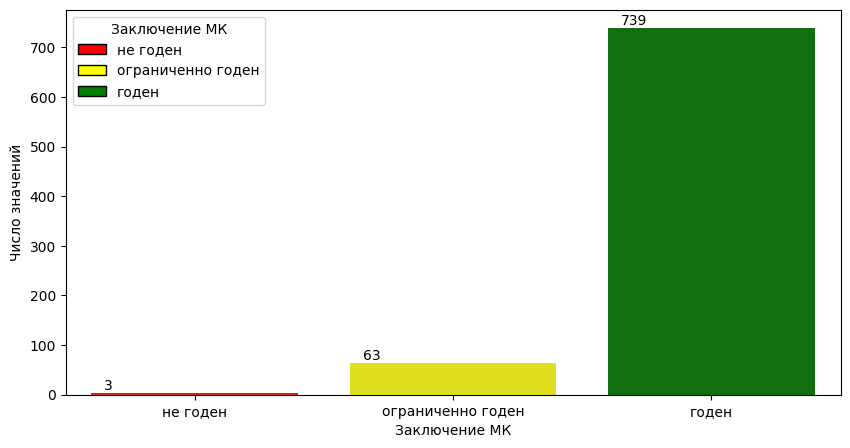

In [340]:
# Визуальная оценка сбалансированности датасета до ресемплинга

from matplotlib.patches import Patch

conclusion_lst = ['не годен', 'ограниченно годен', 'годен']

conclusion_count_arr = np.zeros(3, dtype=int)
# не годен
conclusion_count_arr[0] = len(lst0)
# ограниченно годен
conclusion_count_arr[1] = len(lst1)+len(lst2)+len(lst3)+len(lst4)
# годен
conclusion_count_arr[2] = len(lst5)

print(f'0: не годен: {conclusion_count_arr[0]}')
print(f'1: ограниченно годен: {conclusion_count_arr[1]}')
print(f'2: годен: {conclusion_count_arr[2]}')

plt.figure(figsize=(10, 5))
plot0 = sns.barplot(x=conclusion_lst, y=conclusion_count_arr, palette=["red", "yellow", "green"])
plt.xlabel("Заключение МК")
plt.ylabel("Число значений")
legend_elements = [Patch(facecolor='red', edgecolor='black', label='не годен'),
                   Patch(facecolor='yellow', edgecolor='black', label='ограниченно годен'),
                   Patch(facecolor='green', edgecolor='black', label='годен')]
plt.legend(handles=legend_elements, title="Заключение МК")
# выводим значения над столбиками
for p in plot0.patches:
  plot0.annotate(text='{}'.format(int(p.get_height())),xy=(p.get_x() + 0.05, p.get_height() + 7.5))
plt.show()

**2023.06.24. не балансирую датасет в ожидании файлов с подписанными колонками.**

In [341]:
# # создаем копию нужных строк и добавляем их в отдельный df
# adf0 = df1.loc[lst0].copy()
# print(f'размеры датафрейма adf0: {adf0.shape}, len(lst0): {len(lst0)}')

# adf1 = df1.loc[lst1].copy()
# print(f'размеры датафрейма adf1: {adf1.shape}, len(lst1): {len(lst1)}')

# adf2 = df1.loc[lst2].copy()
# print(f'размеры датафрейма adf2: {adf2.shape}, len(lst2): {len(lst2)}')

# adf3 = df1.loc[lst3].copy()
# print(f'размеры датафрейма adf3: {adf3.shape}, len(lst3): {len(lst3)}')

# adf4 = df1.loc[lst4].copy()
# print(f'размеры датафрейма adf4: {adf4.shape}, len(lst4): {len(lst4)}')

In [342]:
# print(f'размеры датафрейма: df1: {df1.shape}')

# # добавляем новый df в исходный df

# # for i in range(2):
# for i in range(1):
#   for j in range(80):
#     df1 = pd.concat([df1, adf0], ignore_index=True)
#   df1 = pd.concat([df1, adf1], ignore_index=True)
#   for j in range(200):
#     df1 = pd.concat([df1, adf2], ignore_index=True)
#   for j in range(100):
#     df1 = pd.concat([df1, adf3], ignore_index=True)
#     df1 = pd.concat([df1, adf4], ignore_index=True)

# print('='*50)
# print(f'размеры датафрейма: df1: {df1.shape}')

In [343]:
# # Смотрим новые значения целевой колонки
# lst0.clear()
# lst1.clear()
# lst2.clear()
# lst3.clear()
# lst4.clear()
# lst5.clear()

# col_lst = df1.iloc[:, col_inx].tolist()
# for i in range(df1.shape[0]):
#   i_elem = col_lst[i]
#   if (i_elem == i_elem):
#     if i_elem:
#       if not (('машинист бульдозера' == i_elem) or ('Газоспасатель' == i_elem) or (' Газоспасатель' == i_elem)):
#         if 'ВременноНегоден' == i_elem:
#           lst0.append(i)
#         elif 'ГоденСКоррекциейЗрения' == i_elem:
#           lst1.append(i)
#         elif 'ГоденБезРаботНаВысотах' == i_elem:
#           lst2.append(i)
#         elif 'НуждаетсяВДообследованииИЛечении' == i_elem:
#           lst3.append(i)
#         elif 'ОграниченноГоден' == i_elem:
#           lst4.append(i)
#         elif 'Годен' == i_elem:
#           lst5.append(i)
#         else:
#           print(f'{i}->{df1.shape[0]}: i_elem: {i_elem} -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП')

# print(f'df1 число строк: {df1.shape[0]}')

# print(f'0: ВременноНегоден: {len(lst0)}')
# print(f'1: ГоденСКоррекциейЗрения: {len(lst1)}')
# print(f'2: ГоденБезРаботНаВысотах: {len(lst2)}')
# print(f'3: НуждаетсяВДообследованииИЛечении: {len(lst3)}')
# print(f'4: ОграниченноГоден: {len(lst4)}')
# print(f'5: Годен: {len(lst5)}')

# print('проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:')
# print(f'  {df1.shape[0]} -> {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)+len(lst5)}')
# print(f'  Годен: {len(lst5)}')
# print(f'  Негоден, Ограниченно годен: {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)}')

In [344]:
# # Визуальная оценка сбалансированности датасета после ресемплинга

# # не годен
# conclusion_count_arr[0] = len(lst0)
# # ограниченно годен
# conclusion_count_arr[1] = len(lst1)+len(lst2)+len(lst3)+len(lst4)
# # годен
# conclusion_count_arr[2] = len(lst5)

# print(f'0: не годен: {conclusion_count_arr[0]}')
# print(f'1: ограниченно годен: {conclusion_count_arr[1]}')
# print(f'2: годен: {conclusion_count_arr[2]}')

# plt.figure(figsize=(10, 5))
# plot1 = sns.barplot(x=conclusion_lst, y=conclusion_count_arr, palette=["red", "yellow", "green"])
# plt.xlabel("Заключение МК")
# plt.ylabel("Число значений")
# legend_elements = [Patch(facecolor='red', edgecolor='black', label='не годен'),
#                    Patch(facecolor='yellow', edgecolor='black', label='ограниченно годен'),
#                    Patch(facecolor='green', edgecolor='black', label='годен')]
# plt.legend(handles=legend_elements, title="Заключение МК")
# # выводим значения над столбиками
# for p in plot1.patches:
#   plot1.annotate(text='{}'.format(int(p.get_height())),xy=(p.get_x() + 0.05, p.get_height() + 7.5))
# plt.show()

In [345]:
del lst0
del lst1
del lst2
del lst3
del lst4
del lst5

# del adf0
# del adf1
# del adf2
# del adf3
# del adf4

del conclusion_count_arr

# Приведение датафрейма df1 к категориальному df_code

Название колонки(тип данных): Значения

КлиентID(integer): 0,1,2...N

ЗаключениеМК(integer): 0 - не годен, 1 - ограниченно годен, 2 - годен

Возраст(integer): до 18лет, далее через 5, всего 11 классов: 0-17: 0, 18-22: 1, 23-27: 2, ...., 73..: 10

КлиентПол(integer): 0 - Женский, 1 - Мужской

ВредныеФакторы(string): коды через запятую

In [346]:
# Создаю датафрейм для нейронной сети c целочисленными, категориальными признаками и т.д.
df_code = pd.DataFrame(columns=['КлиентID',
                                'iЗаключениеМК', 'ЗаключениеМК',
                                'iВозраст', 'Возраст',
                                'КлиентПол',
                                'lВредныеФакторы', 'ВредныеФакторы',
                                'ГинекологияМКБ', 'ГинекологияДиагноз', 'Гинекология'
                                ])


# i - integer
# l - list (comma separated value)

df_code['КлиентID'] = df_code['КлиентID'].astype(int)

#~~~~~~~~~~~~~~~~~~~~~~~~
df_code['iЗаключениеМК'] = df_code['iЗаключениеМК'].astype(int)
# one-hot-encoding
df_code['ЗаключениеМК'] = df_code['ЗаключениеМК'].astype(object)

#~~~~~~~~~~~~~~~~~~~~~~~~
df_code['iВозраст'] = df_code['iВозраст'].astype(int)
# one-hot-encoding
df_code['Возраст'] = df_code['Возраст'].astype(object)

#~~~~~~~~~~~~~~~~~~~~~~~~
df_code['КлиентПол'] = df_code['КлиентПол'].astype(int)

#~~~~~~~~~~~~~~~~~~~~~~~~
df_code['lВредныеФакторы'] = df_code['lВредныеФакторы'].astype(str)
# multi-hot-encoding
df_code['ВредныеФакторы'] = df_code['ВредныеФакторы'].astype(object)

#~~~~~~~~~~~~~~~~~~~~~~~~
df_code['ГинекологияМКБ'] = df_code['ГинекологияМКБ'].astype(str)
df_code['ГинекологияДиагноз'] = df_code['ГинекологияДиагноз'].astype(str)
# multi-hot-encoding
df_code['Гинекология'] = df_code['Гинекология'].astype(object)

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~

print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(3)

размеры датафрейма: df1: (806, 15), df_code: (0, 11)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология


## КлиентID

In [347]:
# создаем numpy массив integer из нулей, число элементов равно числу строк
# нашего исходного data frame df1
i_arr = np.zeros(df1.shape[0], dtype=int)
# Заполняем массив последовательными целочисленными значениями
for i in range(df1.shape[0]):
  i_arr[i] = i
  # print(f'{i}->{df1.shape[0]}')

# print('Количество осей: ',i_arr.ndim)
# print('Форма массива: ',i_arr.shape)
# print('Количество значений: ',i_arr.size)
# print(f'i_arr: {i_arr}')

# заполняем колонку 'КлиентID' значениями из массива i_arr
df_code = df_code.assign(КлиентID=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(3)

размеры датафрейма: df1: (806, 15), df_code: (806, 11)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ЗаключениеМК

In [348]:
print('ЗаключениеМК')
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

ЗаключениеМК
  число строк с пустыми значениями: 0
  уникальные значения: 6: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ГоденСКоррекциейСлуха']


In [349]:
# Заполняем колонку 'ЗаключениеМК' категориальными признаками
# 0 - не годен, 1 - ограниченно годен, 2 - годен
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ЗаключениеМК'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getConclusionCategory(arg):
  '''
    Получение целевого категориального значения по текстовому описанию
    вход:
        arg: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']
    выход:
        0 - не годен, 1 - ограниченно годен, 2 - годен
  '''
  retVal = 1
  if ('НуждаетсяВДообследованииИЛечении' == arg) or ('ВременноНегоден' == arg):
    retVal = 0
  elif 'Годен' == arg:
    retVal = 2

  return retVal

In [350]:
# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()

# Заполняем массив категориальными индексами
for i in range(df1.shape[0]):
  i_arr[i] = getConclusionCategory(col_lst[i])

# Заполняем колонку 'iЗаключениеМК' значениями из массива i_arr
df_code = df_code.assign(iЗаключениеМК=i_arr)

# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(i_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# Заполняем колонку 'ЗаключениеМК' значениями из массива ohe_lst2
df_code = df_code.assign(ЗаключениеМК=ohe_lst2)

print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(3)

размеры датафрейма: df1: (806, 15), df_code: (806, 11)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология
0,0,2,"[0, 0, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,"[0, 0, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,"[0, 0, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Возраст

In [351]:
print('Возраст')
# КлиентДатаРождения
print('  КлиентДатаРождения')
nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'    число строк с пустыми значениями: {len(nan_lst)}')
# ДатаЗавершенияМедосмотра
print('  ДатаЗавершенияМедосмотра')
nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'    число строк с пустыми значениями: {len(nan_lst)}')

Возраст
  КлиентДатаРождения
    число строк с пустыми значениями: 0
  ДатаЗавершенияМедосмотра
    число строк с пустыми значениями: 0


In [352]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода Возраст клиента
#~~~~~~~~~~~~~~~~~~~~~~~~
# Возраст клиента = ДатаЗавершенияМедосмотра - КлиентДатаРождения
#~~~~~~~~~~~~~~~~~~~~~~~~
def getAgeCategory(ageN, ageClassCount):
  '''
    Возраст превращаем в категориальный: до 18лет, далее через 5, всего 11 классов
    вход:
        ageN: возраст в годах
        ageClassCount: число классов
    выход:
        retVal: индекс категории: 0-17: 0, 18-22: 1, 23-27: 2, ...., 73..: 10
  '''
  #age2 = int((arg-13)/5)
  age2 = (ageN-13)/5
  retVal = max(0, min((ageClassCount-1),age2))
  return retVal

In [353]:
# КлиентДатаРождения
col_inx = df1.columns.get_loc('КлиентДатаРождения')
col_lst = df1.iloc[:, col_inx].tolist()
datetime_lst1 = []
for time_stamp in col_lst:
  # 2023.06.24 тип колонки изменен
  # datetime_obj = time_stamp.to_pydatetime()
  # datetime_lst1.append(datetime_obj)
  #~~~
  # print(f'time_stamp: {time_stamp}')
  # time_stamp: 1979-07-16T00:00:00
  datetime_obj = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S')
  datetime_lst1.append(datetime_obj)

# ДатаЗавершенияМедосмотра
col_inx = df1.columns.get_loc('ДатаЗавершенияМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()
datetime_lst2 = []
for time_stamp in col_lst:
  # # 2023.06.24 тип колонки изменен
  # datetime_obj = time_stamp.to_pydatetime()
  # datetime_lst2.append(datetime_obj)
  #~~~
  # print(f'time_stamp: {time_stamp}')
  # time_stamp: 2023-05-31T00:00:00
  datetime_obj = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S')
  datetime_lst2.append(datetime_obj)

# рассчитываю возраст клиента
for i in range(df1.shape[0]):
  delta_dates21 = datetime_lst2[i].date() - datetime_lst1[i].date()
  delta_days21 = delta_dates21.days
  i_arr[i] = delta_days21 // 365

# Заполняем колонку 'iВозраст' значениями из массива i_arr
df_code = df_code.assign(iВозраст=i_arr)

# Преобразование массива в формат one_hot_encoding (11-классов)
# рассчитываю категориальный возраст клиента
for i in range(df1.shape[0]):
  i_arr[i] = getAgeCategory(i_arr[i], 11)

i_arr2 = utils.to_categorical(i_arr, 11)
ohe_lst2 = i_arr2.astype(int).tolist()
# Заполняем колонку 'Возраст' значениями из массива ohe_lst2
df_code = df_code.assign(Возраст=ohe_lst2)

# удаление переменных, освобождение памяти
del datetime_lst1
del datetime_lst2

print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(3)

размеры датафрейма: df1: (806, 15), df_code: (806, 11)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология
0,0,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,"[0, 0, 1]",35,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN


## КлиентПол

In [354]:
print('КлиентПол')
nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['КлиентПол'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

КлиентПол
  число строк с пустыми значениями: 0
  уникальные значения: 2: ['Мужской', 'Женский']


In [355]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'КлиентПол'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getGenderCategory(arg):
  '''
    Бинарный пол клиента
    вход:
        arg: ['Женский', 'Мужской']
    выход:
        retVal: 0 - Женский, 1 - Мужской
  '''
  if 'Женский' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [356]:
col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getGenderCategory(col_lst[i])

# Заполняем колонку 'КлиентПол' значениями из массива i_arr
df_code = df_code.assign(КлиентПол=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(3)

размеры датафрейма: df1: (806, 15), df_code: (806, 11)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология
0,0,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,NaN,NaN,NaN,NaN,NaN
1,1,2,"[0, 0, 1]",35,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,NaN,NaN,NaN,NaN,NaN
2,2,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,NaN,NaN,NaN,NaN,NaN


## ТипМедосмотра - 2023.06.26 - не использую - 'Периодический'

2023.05.08 - 'Периодический', 'Предварительный'

2023.06.26 - 'Периодический'

In [357]:
print('ТипМедосмотра')
nan_lst = df1[df1['ТипМедосмотра'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ТипМедосмотра'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

ТипМедосмотра
  число строк с пустыми значениями: 0
  уникальные значения: 1: ['Периодический']


In [358]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Получение категориального кода 'ТипМедосмотра'
# #~~~~~~~~~~~~~~~~~~~~~~~~
# def getTypeMedExaminationCategory(arg):
#   '''
#     Бинарный Тип Медосмотра
#     вход:
#         arg: ['Периодический', 'Предварительный']
#     выход:
#         retVal: 0 - Периодический, 1 - Предварительный
#   '''
#   if 'Периодический' == arg:
#     retVal = 0
#   else:
#     retVal = 1
#   return retVal

In [359]:
# col_inx = df1.columns.get_loc('ТипМедосмотра')
# col_lst = df1.iloc[:, col_inx].tolist()

# for i in range(df1.shape[0]):
#   i_arr[i] = getTypeMedExaminationCategory(col_lst[i])

# # Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# # добавляем новую колонку 'ТипМедосмотра' в 'df2'
# df2 = df2.assign(ТипМедосмотра=i_arr)

# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

## ПсихОсвидетельствование - 2023.06.26 - не использую - False

2023.05.08 - False, True

2023.06.26 - False

In [360]:
print('ПсихОсвидетельствование')
nan_lst = df1[df1['ПсихОсвидетельствование'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ПсихОсвидетельствование'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

ПсихОсвидетельствование
  число строк с пустыми значениями: 0
  уникальные значения: 2: [False, True]


In [361]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Получение категориального кода 'ПсихОсвидетельствование'
# #~~~~~~~~~~~~~~~~~~~~~~~~
# def getPsychicExaminationCategory(arg):
#   '''
#     Бинарный Тип ПсихОсвидетельствование
#     вход:
#         arg: [False, True]
#     выход:
#         retVal: 0 - False, 1 - True
#   '''
#   if False == arg:
#     retVal = 0
#   else:
#     retVal = 1
#   return retVal

In [362]:
# col_inx = df1.columns.get_loc('ПсихОсвидетельствование')
# col_lst = df1.iloc[:, col_inx].tolist()

# for i in range(df1.shape[0]):
#   i_arr[i] = getPsychicExaminationCategory(col_lst[i])

# # Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# # добавляем новую колонку 'ПсихОсвидетельствование' в 'df2'
# df2 = df2.assign(ПсихОсвидетельствование=i_arr)

# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

## ДиспансернаяГруппа - 2023.06.26 - не использую - нет такого поля

2023.05.08 - ДиспансернаяГруппа

2023.06.26 - нет такого поля

In [363]:
# nan_lst = df1[df1['ДиспансернаяГруппа'].isnull()].index
# print(f'"ДиспансернаяГруппа": число строк с пустыми значениями: {len(nan_lst)}')
# u_lst = df1['ДиспансернаяГруппа'].unique().tolist()
# print(f'{len(u_lst)}: {u_lst}')

In [364]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Получение категориального кода 'ДиспансернаяГруппа'
# #~~~~~~~~~~~~~~~~~~~~~~~~
# def getDispensaryGroupCategory(arg):
#   '''
#     Категориальный Тип ДиспансернаяГруппа
#     вход:
#         один из элементов массива уникальных значений: ['I', 'IIIа', 'II', 'IIIб']
#     выход:
#         retVal: индекс элемента в массиве уникальных значений:
#           0 - nan, 1 - 'I', 2 - 'IIIа', 3 - 'II', 4 - 'IIIб'
#   '''
#   if 'I' == arg:
#     retVal = 1
#   elif 'IIIа' == arg:
#     retVal = 2
#   elif 'II' == arg:
#     retVal = 3
#   elif 'IIIб' == arg:
#     retVal = 4
#   else:
#     retVal = 0

#   return retVal

In [365]:
# dispensary_class_count = 5

# col_inx = df1.columns.get_loc('ДиспансернаяГруппа')
# col_lst = df1.iloc[:, col_inx].tolist()

# # Заполняем массив категориальными индексами
# for i in range(df1.shape[0]):
#   i_arr[i] = getDispensaryGroupCategory(col_lst[i])

# # Преобразование массива в формат one_hot_encoding (5-классов)
# i_arr2 = utils.to_categorical(i_arr, dispensary_class_count)
# ohe_lst2 = i_arr2.astype(int).tolist()

# # добавляем новую колонку 'ДиспансернаяГруппа' в 'df2'
# df2 = df2.assign(ДиспансернаяГруппа=ohe_lst2)

# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [366]:
# df2.tail(2)

## ВредныеФакторы

In [367]:
print('ВредныеФакторы')
nan_lst = df1[df1['ВредныеФакторы'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')

ВредныеФакторы
  число строк с пустыми значениями: 0


In [368]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки по запятым
#~~~~~~~~~~~~~~~~~~~~~~~~
def comma_string_split(arg):
  '''
    Расщепление строки по запятым, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых
    выход:
        retVal: список строк, разделенных запятыми,
        если строк пустая или nan, то вернется пустой список,
        если строка не содержит запятые, то вернется список, состоящий из одного элемента
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # приводим к нижнему регистру, удаляем пробелы в начале и конце слова
      #str1 = arg.lower().strip()
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          retVal.append(str_item2)

  return retVal

In [369]:
# Формируем столбец-список значений вредных факторов, заменяем nan - пустыми строками,
# убираем пробелы перед и после значений
col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst = df1.iloc[:, col_inx].tolist()
#print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

In [370]:
# Harmful Factors
hf_lst = list()

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  elem_str = ""
  #print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      elem_str = ",".join(elem_lst)
      # print(f'{len(elem_lst)}: {elem_lst} ->  {elem_str}')

  # print(f'{i}: {elem_str}')
  hf_lst.append(elem_str)

# print(f'{len(hf_lst)}: {hf_lst}')

# Заполняем колонку 'lВредныеФакторы' значениями из массива hf_lst
df_code = df_code.assign(lВредныеФакторы=hf_lst)

del hf_lst

print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(3)

размеры датафрейма: df1: (806, 15), df_code: (806, 11)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология
0,0,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"18.2,23,4.3.2,5.1,1.50",NaN,NaN,NaN,NaN
1,1,2,"[0, 0, 1]",35,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50",NaN,NaN,NaN,NaN
2,2,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50",NaN,NaN,NaN,NaN


In [371]:
# Формируем список уникальных значений вредных факторов
# Harmful Factors
u_hf_lst = list()

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  #print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      #print(f'  {len(elem_lst)}: {elem_lst}')
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          #print(f'    elem1_lst: {elem1_lst}')
          if len(u_hf_lst) > 0:
            # проверяем, что этого элемента нет в списке
            flag_lst = elem1_lst in u_hf_lst
            if not flag_lst:
              u_hf_lst.append(elem1_lst)
          else:
            u_hf_lst.append(elem1_lst)

#print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

In [372]:
# Оценим число повторений ВредныхФакторов,
# будем использовать в нейросети только наиболее частые,
# остальные, которые встречаются редко обозначим - "все остальные"
# Создаем словарь ВредныеФакторы: ключи - названия вредных факторов, значения - число повторений
u_hf_dict = {}
for i_elem in u_hf_lst:
  u_hf_dict[i_elem] = 0

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# пробегаемся по всем строкам колонки и заполняем словарь
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          u_hf_dict[elem1_lst] += 1

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# сортируем словарь по убыванию
u_hf_sort_dict = dict(sorted(u_hf_dict.items(), key=lambda x: x[1], reverse=True))

# print(f'{len(u_hf_sort_dict)}: u_hf_sort_dict: {u_hf_sort_dict}')

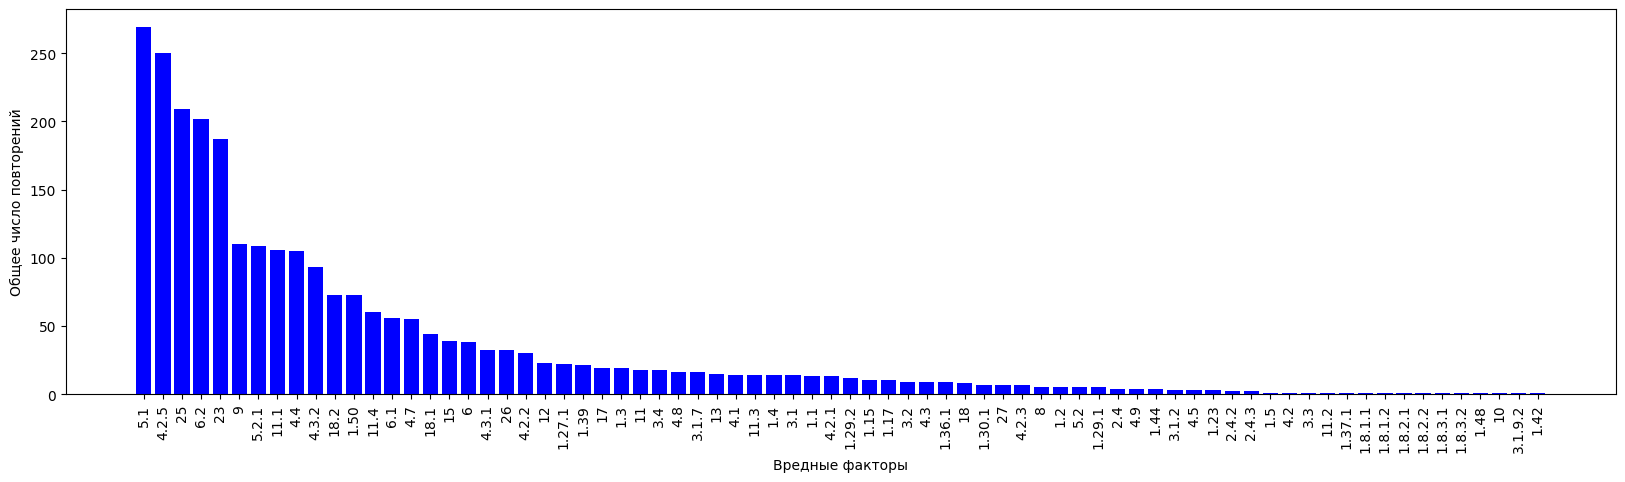

In [373]:
# Отобразим на столбчатую диаграмму - частоту использования наших признаков
plt.figure(figsize=(20, 5))
plt.bar(u_hf_sort_dict.keys(), u_hf_sort_dict.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('Вредные факторы')
plt.ylabel('Общее число повторений')
plt.gca().set_facecolor('white')
plt.show()

In [374]:
# Из графика хорошо видно, что основное влияние оказывают первые 5-7 признаков,
# `с запасом` оставим первые 15 признаков
u_hf_lst = list(u_hf_sort_dict.keys())[:15]
del u_hf_dict
del u_hf_sort_dict

print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

15: u_hf_lst: ['5.1', '4.2.5', '25', '6.2', '23', '9', '5.2.1', '11.1', '4.4', '4.3.2', '18.2', '1.50', '11.4', '6.1', '4.7']


In [375]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
hf_mhe_lst = list()

# число классов
harmful_factors_class_count = len(u_hf_lst) + 1
# то есть по умолчанию выбираем индекс вредного фактора, которого нет в списке
# наших выбранных и ограниченных уникальных вредных факторов - вредный фактор - `все остальные`
nan_inx = len(u_hf_lst)

# print(f'{len(col_lst)}: col_lst: {col_lst}')
# print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')
# print(f'harmful_factors_class_count: {harmful_factors_class_count}')
# print(f'nan_inx: {nan_inx}')

# пробегаемся по всем строкам колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * harmful_factors_class_count
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          # проверяем, есть ли этот элемент в списке
          if elem1_lst in u_hf_lst:
            inx = u_hf_lst.index(elem1_lst)
            i_mhe_lst[inx] = 1
          else:
            i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1
  else:
    i_mhe_lst[nan_inx] = 1

  # print(f'  {len(i_mhe_lst)}: {i_mhe_lst}')
  hf_mhe_lst.append(i_mhe_lst)

# print(f'{len(hf_mhe_lst)}: hf_mhe_lst: {hf_mhe_lst}')

# добавляем новую колонку 'ВредныеФакторы' в 'df2'
df_code = df_code.assign(ВредныеФакторы=hf_mhe_lst)

del hf_mhe_lst

print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(3)

размеры датафрейма: df1: (806, 15), df_code: (806, 11)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология
0,0,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"18.2,23,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",NaN,NaN,NaN
1,1,2,"[0, 0, 1]",35,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",NaN,NaN,NaN
2,2,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",NaN,NaN,NaN


## Гинекология

In [376]:
def getColNamesByFragmentName(str):
  '''
    Возвращает список названий колонок, в которых содержится заданная строка
    вход:
        str - часть названия колонки, например мкб
    выход:
        retVal - список названий колонок, содержащих заданную строку
  '''
  totalCols = list(df1.columns)
  retVal = [col for col in totalCols if str in col]
  return retVal

In [377]:
# Находим все колонки, в которых присутсвует часть названия 'Гинекология'
fragment_str = 'Гинекология'
# Gynecology
gynecology_cols = getColNamesByFragmentName(fragment_str)
# Сортируем список
gynecology_cols.sort()

print(f'Число колонок, содержащих "{fragment_str}": {len(gynecology_cols)}')
print('-'*50)
for i in range(len(gynecology_cols)):
  print(f'{i}: {gynecology_cols[i]}')

Число колонок, содержащих "Гинекология": 6
--------------------------------------------------
0: Гинекология1_Диагноз_Значение
1: Гинекология1_ДиагнозПредставление1
2: Гинекология1_МКБ101
3: Гинекология2_Диагноз_Значение
4: Гинекология2_ДиагнозПредставление1
5: Гинекология2_МКБ101


In [378]:
df_gynecology = df1[gynecology_cols].copy()
df_gynecology.head(20)

,Гинекология1_Диагноз_Значение,Гинекология1_ДиагнозПредставление1,Гинекология1_МКБ101,Гинекология2_Диагноз_Значение,Гинекология2_ДиагнозПредставление1,Гинекология2_МКБ101
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


In [379]:
del gynecology_cols
del df_gynecology

Выбираю колонки 'Гинекология1_Диагноз_Значение', если в ней отсутствует код МКБ, то смотрю МКБ-код в колонке 'Гинекология1_МКБ101' и в 'Гинекология1_ДиагнозПредставление1' описание.

Гинекология1_Диагноз_Значение - [N84.1] Полип шейки матки\r\n

Гинекология1_ДиагнозПредставление1 - Полип шейки матки

Гинекология1_МКБ101 - N84.1

Гинекология1_Диагноз_Значение - [N95.1] Менопаузные и климактерические состоян...

Гинекология1_ДиагнозПредставление1 - NaN

Гинекология1_МКБ101 - NaN

Гинекология1_Диагноз_Значение - ОБЩИЙ МЕДИЦИНСКИЙ ОСМОТР

Гинекология1_ДиагнозПредставление1 - Общий медицинский осмотр

Гинекология1_МКБ101 - Z00.0

Объединяю МКБ-коды профильных врачей в одну колонку: врач1,врач2,врач3,врач4.

Пустые(nan) значения помечаю как MKB_NAN, пустые описания - ''.
Обновляю список признаков по гендерному типу, всю гинекологию у мужчин помечаю как MKB_NAN.

Массив уникальных значений кодов МКБ считаю категориальным.

In [380]:
mkb_nan_str = 'MKB_NAN'

In [381]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Формирование исправленного списка кодов МКБ('_Диагноз_Значение', '_МКБ')
# и описания '_ДиагнозПредставление'
#~~~~~~~~~~~~~~~~~~~~~~~~
def check_patch_mkb_diagnosis(col_name1, col_name2, col_name3):
  '''
    Формированине списка значений кодов мкб и описаний
    вход:
      col_name1 - _Диагноз_Значение(Гинекология1_Диагноз_Значение)
      col_name2 - _ДиагнозПредставление1(Гинекология1_ДиагнозПредставление1)
      col_name3 - _МКБ101(Гинекология1_МКБ101)
    выход:
      retVal: список mkb-кодов+описание:  N84.1|Полип шейки матки
  '''
  retVal = list()
  retVal = [''] * df1.shape[0]

  # print(f'df1 число строк : {df1.shape[0]}')
  # print(f'df1 число столбцов : {df1.shape[1]}')
  # print(f'retVal: {len(retVal)} : {retVal}')

  # print('список колонок для формирования списка МКБ+Диагноз:')
  # print(f'  {col_name1}')
  # print(f'  {col_name2}')
  # print(f'  {col_name3}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  col_inx = df1.columns.get_loc(col_name1)
  col_lst1 = df1.iloc[:, col_inx].tolist()
  col_inx = df1.columns.get_loc(col_name2)
  col_lst2 = df1.iloc[:, col_inx].tolist()
  col_inx = df1.columns.get_loc(col_name3)
  col_lst3 = df1.iloc[:, col_inx].tolist()
  # print(f'col_lst1: {len(col_lst1)}: {col_lst1}')
  # print(f'col_lst2: {len(col_lst2)}: {col_lst2}')
  # print(f'col_lst3: {len(col_lst3)}: {col_lst3}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  # пробегаемся по всем строкам колонки
  for i in range(df1.shape[0]):
    mkb_elem = mkb_nan_str+'|'
    # diagnosis_elem = ''
    #~~~
    i_elem1 = col_lst1[i]
    i_elem2 = col_lst2[i]
    i_elem3 = col_lst3[i]
    # print(f'{i}->{df1.shape[0]}: i_elem1: {i_elem1}, i_elem2: {i_elem2}, i_elem3: {i_elem3}')
    #~~~
    # проверяем на nan 2-ую и 3-ью колонки
    if (i_elem2 == i_elem2):
      # проверяем, что строки не пустые
      if i_elem2:
        if (i_elem3 == i_elem3):
          if i_elem3:
            mkb_elem = (str(i_elem3)).strip()+'|'+(str(i_elem2)).strip()
            # print(f'  3->2: {i}: `{mkb_elem}`')
    #~~~
    # обрабатываю 1-ую колонку
    if (i_elem1 == i_elem1):
      # проверяем, что строка не пустая
      if i_elem1:
        str1 = (str(i_elem1)).strip()
        if "[" in str1 and "]" in str1:
          mkb_start = str1.find("[") + 1
          mkb_end = str1.find("]")
          mkb_str1 = str1[mkb_start:mkb_end]
          mkb_str2 = mkb_str1.strip()
          mkb_end = mkb_end + 1
          diagnosis_str1 = str1[mkb_end:]
          diagnosis_str2 = diagnosis_str1.strip()
          # print(f'  mkb_str2: `{mkb_str2}`, diagnosis_str2: `{diagnosis_str2}`')
          #~~~
          mkb_elem = mkb_str2 + '|' + diagnosis_str2
    #~~~
    #print(f'  mkb_elem: `{mkb_elem}`')
    retVal[i] = mkb_elem

  #~~~~~~~~~~~~~~~~~~~~~~~~
  del col_inx
  del col_lst1
  del col_lst2
  del col_lst3

  #~~~~~~~~~~~~~~~~~~~~~~~~
  return retVal

In [382]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Объединение кодов мкб от врача-1,врача-2,врача-3,врача-4 в одну колонку
#~~~~~~~~~~~~~~~~~~~~~~~~
def mkb1234_merge(lst1234):
  '''
    Объединение кодов мкб от врача-1,врача-2,врача-3,врача-4 в одну колонку
    вход:
        lst1234: список списков исправленных значений мкб+диагноз
    выход:
        retVal: список объединенных mkb-кодов
  '''
  retVal = list()
  retVal = [''] * df1.shape[0]

  # print(f'df1 число строк : {df1.shape[0]}')
  # print(f'df1 число столбцов : {df1.shape[1]}')
  # print(f'{len(retVal)} : {retVal}')

  for j in range(len(lst1234)):
    lst1 = lst1234[j];
    # print(f'{j}->{len(lst1234)}: {lst1234[j]}')
    # print(f'  lst1: {len(lst1)}: {lst1}')
    # пробегаемся по всем элементам списка
    for i in range(len(lst1)):
      str1 = lst1[i]
      # print(f'{j}->{i}->{len(lst1)}: {str1}')
      str2, str3 = str1.split('|')
      # print(f'  str2: `{str2}`, str3: `{str3}`')
      if mkb_nan_str != str2:
        if "" == retVal[i]:
          retVal[i] = str2
        elif not (str2 in retVal[i]):
          retVal[i] += ',' + str2
          # print(f'    составной МКБ: `{retVal[i]}`')
      # print(f'    МКБ: `{retVal[i]}`')

  # заполняю MKB_NAN
  for i in range(len(retVal)):
    # print(f'{i}-{len(retVal)}: `{retVal[i]}`')
    # проверяем, что строка не пустая, если пустая, значит это nan
    if not retVal[i]:
      # print('  ->nan')
      retVal[i] = mkb_nan_str
      # print(f'  ->nan: `{retVal[i]}`')

  return retVal

In [383]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Объединение кодов мкб от врача-1,врача-2,врача-3,врача-4 в одну колонку
#~~~~~~~~~~~~~~~~~~~~~~~~
def diagnosis1234_merge(lst1234):
  '''
    Объединение диагнозов от врача-1,врача-2,врача-3,врача-4 в одну колонку
    вход:
        lst1234: список списков исправленных значений мкб+диагноз
    выход:
        retVal: список объединенных диагнозов
  '''
  retVal = list()
  retVal = [''] * df1.shape[0]

  # print(f'df1 число строк : {df1.shape[0]}')
  # print(f'df1 число столбцов : {df1.shape[1]}')
  # print(f'{len(retVal)} : {retVal}')

  for j in range(len(lst1234)):
    lst1 = lst1234[j];
    # print(f'{j}->{len(lst1234)}: {lst1234[j]}')
    # print(f'  lst1: {len(lst1)}: {lst1}')
    # пробегаемся по всем элементам списка
    for i in range(len(lst1)):
      str1 = lst1[i]
      # print(f'{j}->{i}->{len(lst1)}: {str1}')
      str2, str3 = str1.split('|')
      # print(f'  str2: `{str2}`, str3: `{str3}`')
      if mkb_nan_str != str2:
        if "" == retVal[i]:
          retVal[i] = str2 + '-' + str3
        elif not (str2 in retVal[i]):
          retVal[i] += ', ' + str2 + '-' + str3
          # print(f'    составной диагноз: `{retVal[i]}`')
      # print(f'    диагноз: `{retVal[i]}`')

  return retVal

In [384]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение списка уникальных значений кодов МКБ по профильным специалистам:
# врач1,врач2,врач3,врач4
#~~~~~~~~~~~~~~~~~~~~~~~~
def umkb1234(lst1234):
  '''
    Получение списка уникальных значений кодов МКБ по профильным специалистам:
    врач1,врач2,врач3,врач4
    вход:
        lst1234: список списков исправленных значений мкб+диагноз
    выход:
        retVal: список уникальных mkb-кодов
  '''
  retVal = list()

  # print(f'df1 число строк : {df1.shape[0]}')
  # print(f'df1 число столбцов : {df1.shape[1]}')
  # print(f'{len(retVal)} : {retVal}')

  ulst1 = list()
  for j in range(len(lst1234)):
    lst1 = lst1234[j];
    # пробегаемся по всем элементам списка
    for i in range(len(lst1)):
      str1 = lst1[i]
      str2, str3 = str1.split('|')
      #~~~
      if 0 == len(ulst1):
        ulst1.append(str2)
      else:
        if not (str2 in ulst1):
          ulst1.append(str2)
      # print(f'{i}->{len(lst1)}: ulst1: `{ulst1}`')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  if mkb_nan_str in ulst1:
    retVal.append(mkb_nan_str)

  ulst2 = sorted(ulst1)
  for i in range(len(ulst2)):
    if not (ulst2[i] in retVal):
      retVal.append(ulst2[i])

  #~~~~~~~~~~~~~~~~~~~~~~~~
  del ulst1
  del ulst2
  #~~~~~~~~~~~~~~~~~~~~~~~~
  return retVal

In [385]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Формирование списка multi-hot-encoding
#~~~~~~~~~~~~~~~~~~~~~~~~
def get_mhe_lst(mkb_lst, umkb_lst):
  '''
    Формирование списка multi-hot-encoding
    вход:
        mkb_lst: список мкб-кодов (если несколько значений для одного клиента, то значения через запятую)
        umkb_lst: список список уникальных мкб-кодов
    выход:
        mhe_lst: список multi-hot-encoding
  '''
  #~~~~~~~~~~~~~~~~~~~~~~~~
  #multi-hot-encoding
  mhe_lst = list()
  # число классов
  mhe_class_count = len(umkb_lst)
  # print(f'mhe_class_count: {mhe_class_count}')
  for i in range(df1.shape[0]):
    # устанавливаем все признаки в нули
    i_mhe = [0] * mhe_class_count
    mhe_lst.append(i_mhe)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  # Считаю mkb_lst -> массивом категориальных значений
  # Заполняю массив категориальными индексами
  #~
  #mkb_nan_str = 'MKB_NAN' - всегда устанавливаю по нулевому индексу
  nan_inx = 0
  for i in range(len(mkb_lst)):
    # считываем все признаки
    i_mhe = mhe_lst[i]
    # print(f'i:{i}: i_mhe:{i_mhe}')
    # и заполняем все признаки
    # print(f'{i}->{len(mkb_lst)}: {mkb_lst[i]}')
    elem_lst = comma_string_split(mkb_lst[i])
    for elem1_lst in elem_lst:
      # проверяем, есть ли этот элемент в списке
      # print(f'{i}->{len(mkb_lst)}: elem1_lst: {elem1_lst}')
      if elem1_lst in umkb_lst:
        inx = umkb_lst.index(elem1_lst)
        i_mhe[inx] = 1
      else:
        # невозможный случай, но дополнительная проверка
        i_mhe[nan_inx] = 1
    # и обновляем multi-hot-encoding элемент
    # print(f'i:{i}: i_mhe:{i_mhe}')
    mhe_lst[i] = i_mhe

  #~~~~~~~~~~~~~~~~~~~~~~~~
  # print(f'mhe_lst: {len(mhe_lst)}: {mhe_lst}')
  return mhe_lst

In [386]:
#~~~Гинекология
col_name1 = 'Гинекология1_Диагноз_Значение'
col_name2 = 'Гинекология1_ДиагнозПредставление1'
col_name3 = 'Гинекология1_МКБ101'
mkb_col1 = check_patch_mkb_diagnosis(col_name1, col_name2, col_name3)
# print(f'МКБ+Диагноз: {len(mkb_col1)}: {mkb_col1} ')
#~~~
col_name1 = 'Гинекология2_Диагноз_Значение'
col_name2 = 'Гинекология2_ДиагнозПредставление1'
col_name3 = 'Гинекология2_МКБ101'
mkb_col2 = check_patch_mkb_diagnosis(col_name1, col_name2, col_name3)
# print(f'МКБ+Диагноз: {len(mkb_col2)}: {mkb_col2} ')

#~~~объединение кодов мкб
mkb_col1234 = list()
mkb_col1234.append(mkb_col1)
mkb_col1234.append(mkb_col2)
#~
mkb1234_lst = mkb1234_merge(mkb_col1234)
# print(f'mkb1234_lst: {len(mkb1234_lst)}: {mkb1234_lst} ')

#~~~объединение диагнозов
diagnosis1234_lst = diagnosis1234_merge(mkb_col1234)
# print(f'diagnosis1234_lst: {len(diagnosis1234_lst)}: {diagnosis1234_lst} ')

#~~~получение списка уникальных значений кодов МКБ
umkb1234_lst = umkb1234(mkb_col1234)
# print(f'umkb1234_lst: {len(umkb1234_lst)}: {umkb1234_lst} ')

#~~~~~~~~~~~~~~~~~~~~~~~~
# Гендерный массив, для обработки колонки Гинекология
# 0 - Женский, 1 - Мужской
# все значения мкб-кодов для мужчин исправляю на mkb_nan_str = 'MKB_NAN'
col_inx = df_code.columns.get_loc('КлиентПол')
gender_arr = df_code.iloc[:, col_inx]

gender_lst = df_code.iloc[:, col_inx].tolist()
# print(f'{len(gender_lst)}: {gender_lst}')
for i in range(df1.shape[0]):
  # print(f'{i}->{df1.shape[0]}: {gender_arr[i]}')
  # if 0 == gender_arr[i]:
  #   print(f'  женский')
  # elif 1 == gender_arr[i]:
  #   print(f'  мужской')
  if 1 == gender_arr[i]:
    mkb1234_lst[i] = mkb_nan_str

# print(f'с проверкой-поправкой по мужчинам: mkb1234_lst: {len(mkb1234_lst)}: {mkb1234_lst} ')
del gender_lst
del gender_arr

#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
mhe1234_lst = get_mhe_lst(mkb1234_lst, umkb1234_lst)
# print(f'mhe1234_lst: {len(mhe1234_lst)}: {mhe1234_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~добавляем данные в колонки df_code: 'ГинекологияМКБ', 'ГинекологияДиагноз', 'Гинекология'
df_code = df_code.assign(ГинекологияМКБ=mkb1234_lst)
df_code = df_code.assign(ГинекологияДиагноз=diagnosis1234_lst)
df_code = df_code.assign(Гинекология=mhe1234_lst)

#~~~
print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(20)

размеры датафрейма: df1: (806, 15), df_code: (806, 11)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология
0,0,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"18.2,23,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,2,"[0, 0, 1]",35,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,2,"[0, 0, 1]",40,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,1.50,5.1","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,2,"[0, 0, 1]",28,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,5,2,"[0, 0, 1]",48,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,6,2,"[0, 0, 1]",47,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,7,2,"[0, 0, 1]",46,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1,"18.2,23,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,8,2,"[0, 0, 1]",38,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,1.50,5.1","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,9,2,"[0, 0, 1]",49,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50,23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [387]:
#~очищаем списки
mkb_col1.clear()
mkb_col2.clear()
mkb_col1234.clear()
mkb1234_lst.clear()
diagnosis1234_lst.clear()
umkb1234_lst.clear()
mhe1234_lst.clear()

# Текстовые признаки (Цех+Профессия: Tokenizer-Bag of Words)

считаю, что цех и профессию необходимо объединить в один признак

In [388]:
print(f'размеры датафрейма: df1: {df1.shape}')
nan_lst = df1[df1['Цех'].isnull()].index
print(f'"Цех": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Цех'].unique().tolist()
# print(f'уникальные значения: {len(u_lst)}: {u_lst}')
print(f'уникальные значения: {len(u_lst)}')

размеры датафрейма: df1: (806, 15)
"Цех": число строк с пустыми значениями: 518
уникальные значения: 79


In [389]:
print(f'размеры датафрейма: df1: {df1.shape}')
nan_lst = df1[df1['Профессия'].isnull()].index
print(f'"Профессия": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Профессия'].unique().tolist()
# print(f'уникальные значения: {len(u_lst)}: {u_lst}')
print(f'уникальные значения: {len(u_lst)}')

размеры датафрейма: df1: (806, 15)
"Профессия": число строк с пустыми значениями: 0
уникальные значения: 362


In [390]:
# branch + profession
# результирующий список
brh_prn_lst = [""] * df1.shape[0]
# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Цех
col_inx = df1.columns.get_loc('Цех')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] = i_elem2
    else:
      brh_prn_lst[i] = 'без отдела'
  else:
    brh_prn_lst[i] = 'без отдела'

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Профессия
col_inx = df1.columns.get_loc('Профессия')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] += ' ' + i_elem2

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}')
# пример цех+профессия 123-ей записи-строки
print(brh_prn_lst[123])

df1 число строк: 806, len(brh_prn_lst): 806
ооо «территория еды 102» повар


In [391]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

#определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# maxWordsCount = 10000
# число строк: 3014, len(brh_prn_items): 765, [('unknown', 1), ('отдела', 2), ('без', 3), ('разряда', 4), ('водитель', 5), ('автомобиля', 6), ('по', 7), ('слесарь', 8), ('6', 9)
maxWordsCount = 765

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

# "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
tokenizer.fit_on_texts(brh_prn_lst)

#Вытаскиваем индексы слов для просмотра
brh_prn_items = list(tokenizer.word_index.items())
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_items): {len(brh_prn_items)}, {brh_prn_items}')

df1 число строк: 806, len(brh_prn_items): 548, [('unknown', 1), ('отдела', 2), ('без', 3), ('по', 4), ('и', 5), ('водитель', 6), ('инженер', 7), ('учитель', 8), ('преподаватель', 9), ('оператор', 10), ('ул', 11), ('с', 12), ('№5', 13), ('дмш', 14), ('маоу', 15), ('уоши', 16), ('плп', 17), ('автомобиля', 18), ('продавец', 19), ('цех', 20), ('транспортная', 21), ('40', 22), ('1', 23), ('начальник', 24), ('франко', 25), ('7а', 26), ('повар', 27), ('скважин', 28), ('мастер', 29), ('машинист', 30), ('мбу', 31), ('тренер', 32), ('участок', 33), ('ведущий', 34), ('капитального', 35), ('ремонта', 36), ('старший', 37), ('слесарь', 38), ('языка', 39), ('отдел', 40), ('телеоператор', 41), ('ооо', 42), ('«территория', 43), ('еды', 44), ('102»', 45), ('разряда', 46), ('пдо', 47), ('экспедитор', 48), ('художник', 49), ('аск', 50), ('2', 51), ('специалист', 52), ('г', 53), ('заместитель', 54), ('участка', 55), ('монтажник', 56), ('категории', 57), ('помощник', 58), ('упнр', 59), ('сшор', 60), ('дирек

In [392]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
#обучающие тесты в индексы
brh_prn_inxs = tokenizer.texts_to_sequences(brh_prn_lst)
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_inxs): {len(brh_prn_inxs)}, {brh_prn_inxs}')

df1 число строк: 806, len(brh_prn_inxs): 806, [[3, 2, 6, 48], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 6, 18], [3, 2, 19], [3, 2, 298], [65, 20, 33, 160, 5, 161, 162, 163, 5, 164], [65, 20, 33, 160, 5, 161, 162, 163, 5, 164], [65, 20, 29], [65, 20, 217, 165], [65, 20, 33, 160, 5, 161, 162, 163, 5, 164], [65, 20, 33, 129, 130, 10], [65, 20, 33, 299, 300], [65, 20, 33, 129, 130, 218, 219], [65, 20, 33, 129, 130, 218, 219], [65, 20, 33, 129, 130, 10], [3, 2, 19], [301, 66, 6, 48], [3, 2, 220, 302], [3, 2, 10, 221, 222], [3, 2, 131], [3, 2, 86], [3, 2, 131], [3, 2, 19, 98], [3, 2, 303], [3, 2, 132], [42, 43, 44, 45, 110, 80], [42, 43, 44, 45, 27], [3, 2, 19], [3, 2, 75], [42, 43, 44, 45, 223], [304, 19], [3, 2, 34, 52, 4, 133, 166], [42, 43, 44, 45, 27], [3, 2, 6, 48], [3, 2, 6, 48], [3, 2, 37, 19], [1

In [393]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
# Подаем xTrain в виде списка чтобы метод успешно сработал
xTrainProf01 = tokenizer.sequences_to_matrix(brh_prn_inxs)
# Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01.shape)
print(f'xTrainProf01 число строк : {xTrainProf01.shape[0]}')
print(f'xTrainProf01 число столбцов : {xTrainProf01.shape[1]}')
print(xTrainProf01[0][0:100])

(806, 765)
xTrainProf01 число строк : 806
xTrainProf01 число столбцов : 765
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [394]:
n = 123
# Цех+Профессия
print(brh_prn_lst[n])
# Профессия через индексы
print(brh_prn_inxs[n])

ооо «территория еды 102» повар
[42, 43, 44, 45, 27]


In [395]:
brh_mhe_lst = xTrainProf01.astype(int).tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(brh_mhe_lst): {len(brh_mhe_lst)}, {brh_mhe_lst}')

# добавляем новую колонку 'ЦехПрофессия' в 'df2'
df_code = df_code.assign(ЦехПрофессия=brh_mhe_lst)
#~~~
print(f'размеры датафрейма: df1: {df1.shape}, df_code: {df_code.shape}')
print('='*50)
df_code.head(3)

размеры датафрейма: df1: (806, 15), df_code: (806, 12)


,КлиентID,iЗаключениеМК,ЗаключениеМК,iВозраст,Возраст,КлиентПол,lВредныеФакторы,ВредныеФакторы,ГинекологияМКБ,ГинекологияДиагноз,Гинекология,ЦехПрофессия
0,0,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"18.2,23,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,2,"[0, 0, 1]",35,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,2,"[0, 0, 1]",42,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"23,18.2,4.3.2,5.1,1.50","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",MKB_NAN,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [396]:
del brh_prn_lst
del brh_prn_inxs
del xTrainProf01
del brh_mhe_lst

# Проверка таблицы на пустые ячейки

In [397]:
print(f'df_code число строк: {df_code.shape[0]}')
print(f'df_code число колонок: {df_code.shape[1]}')

nan_cell_count = df_code.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df_code.size
print(f'общее количество пропусков во всей таблице df2: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

df_code число строк: 806
df_code число колонок: 12
общее количество пропусков во всей таблице df2: 0, 0.0%


# Обучение Нейросети

## Удаляю первый датафрейм, чтобы освободить память

In [398]:
#del df1

## Разделяем на отдельные выборки

In [399]:
# y_data
# преобразуем списки в отдельные колонки
df_y = df_code['ЗаключениеМК'].apply(pd.Series)
print(f'размеры датафрейма df_y: {df_y.shape}')
# преобразуем в numpy массив типа float
y_data = df_y.astype(float).to_numpy()
print('Количество осей: ', y_data.ndim)
print('Форма массива: ', y_data.shape)
print('Количество значений: ', y_data.size)

размеры датафрейма df_y: (806, 3)
Количество осей:  2
Форма массива:  (806, 3)
Количество значений:  2418


In [400]:
# x1_data -> категориальные признаки
df_x1 = df_code.drop(['КлиентID',
                      'iЗаключениеМК','ЗаключениеМК',
                      'iВозраст',
                      'lВредныеФакторы',
                      'ГинекологияМКБ','ГинекологияДиагноз'
                      ], axis = 1)

df_x1.head(3)

,Возраст,КлиентПол,ВредныеФакторы,Гинекология,ЦехПрофессия
0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [401]:
# Формируем массив x1_data-категориальные
# трансформируем one-multi-hot-encoding списки в отдельные колонки (для df_x1)
split_col_names = list()
#~~~~~~~~~~~~~~~~~~~~~~~~
split_col_names.append('Возраст')
split_col_names.append('ВредныеФакторы')
split_col_names.append('Гинекология')
split_col_names.append('ЦехПрофессия')
#~~~~~~~~~~~~~~~~~~~~~~~~

for col_name in split_col_names:
  df_x1 = pd.concat([df_x1.drop(col_name, axis=1), df_x1[col_name].apply(pd.Series)], axis=1)

df_x1.head(3)

,КлиентПол,0,1,2,3,4,5,6,7,8,...,755,756,757,758,759,760,761,762,763,764
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [402]:
# преобразуем в numpy массив типа float
x1_data = df_x1.astype(float).to_numpy()
print('Количество осей: ', x1_data.ndim)
print('Форма массива: ', x1_data.shape)
print('Количество значений: ', x1_data.size)

Количество осей:  2
Форма массива:  (806, 809)
Количество значений:  652054


In [403]:
del df_y
del df_x1

## Общие настройки и функции

In [404]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 150
VERBOSE = 1
#percent: 0..1
TEST_DATA_SIZE = 0.15
VALID_DATA_SIZE = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'VALID_DATA_SIZE: {VALID_DATA_SIZE}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 150
VERBOSE: 1
TEST_DATA_SIZE: 0.15
VALID_DATA_SIZE: 0.05


## Обучение нейронной сети

In [405]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           color='blue',
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           color='red',
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
           color='blue',
           label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           color='red',
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

Все данные перевели в категориальные. Приступаем к обучению нейронной сети.

In [406]:
# Создание обучающей и тестовой выборки
x_train, x_test, y_train, y_test = train_test_split(x1_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=TEST_DATA_SIZE, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость
# Выведем размерность полученных выборок
print('Обучающая выборка параметров', x_train.shape)
print('Обучающая выборка меток классов', y_train.shape)
print()
print('Тестовая выборка параметров', x_test.shape)
print('Тестовая выборка меток классов', y_test.shape)

Обучающая выборка параметров (685, 809)
Обучающая выборка меток классов (685, 3)

Тестовая выборка параметров (121, 809)
Тестовая выборка меток классов (121, 3)


In [407]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(30))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(10))

model1.add(Dense(3, activation = 'softmax'))

In [408]:
# Компиляция
model1.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=LEARNING_RATE),
               metrics=['accuracy'])

In [409]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка меток класса
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=VALID_DATA_SIZE,    # Доля проверочной выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/150
6/6 [==============================] - 2s 63ms/step - loss: 1.8077 - accuracy: 0.3262 - val_loss: 1.0114 - val_accuracy: 0.8000
Epoch 2/150
6/6 [==============================] - 0s 14ms/step - loss: 1.4354 - accuracy: 0.4138 - val_loss: 0.9749 - val_accuracy: 0.8571
Epoch 3/150
6/6 [==============================] - 0s 15ms/step - loss: 1.2285 - accuracy: 0.4692 - val_loss: 0.9376 - val_accuracy: 0.8857
Epoch 4/150
6/6 [==============================] - 0s 13ms/step - loss: 1.1328 - accuracy: 0.5123 - val_loss: 0.8931 - val_accuracy: 0.9143
Epoch 5/150
6/6 [==============================] - 0s 14ms/step - loss: 1.0742 - accuracy: 0.5169 - val_loss: 0.8524 - val_accuracy: 0.9143
Epoch 6/150
6/6 [==============================] - 0s 16ms/step - loss: 0.9977 - accuracy: 0.5569 - val_loss: 0.8190 - val_accuracy: 0.9143
Epoch 7/150
6/6 [==============================] - 0s 14ms/step - loss: 0.9536 - accuracy: 0.6015 - val_loss: 0.7917 - val_accuracy: 0.9143
Epoch 8/150
6/6 [===

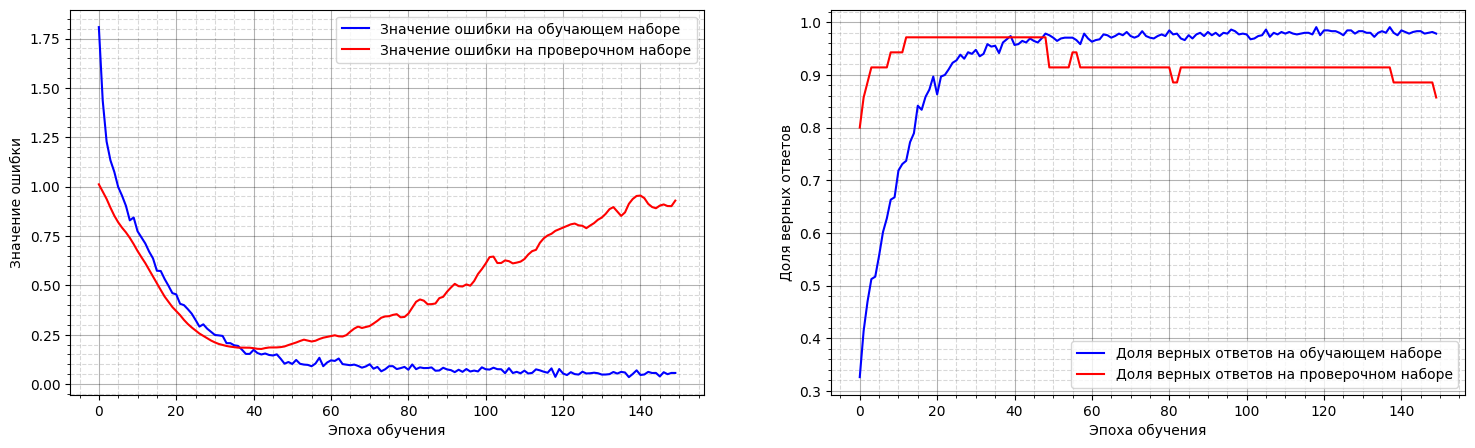

In [410]:
# Отобразим результаты на графике
printNNChart(history1)

In [411]:
# Оценим результат работы нашей сети.
# Применим метод .evaluate() к нашей модели, в качестве параметров
# передадим ему тестовые выборки и согласие на отображение хода вычисления.

scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

4/4 [==============================] - 0s 5ms/step - loss: 1.5547 - accuracy: 0.8264
Процент верных ответов на тестовых данных: 83.0 %


In [412]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
print(f'Эпохи: {EPOCHS}')
print("="*50)

# val_accuracy
val_acc1 = history1.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
for i in range(EPOCHS):
  # print(f'{i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc1[i] > val_acc_max:
    val_acc_max = val_acc1[i]
    i_max = i

print(f'Самая точная нейронка под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc1[i]*100., 3)}%')

Эпохи: 150
Самая точная нейронка под номером: 12 из 150 эпох
  достигла точности: 85.714%


## F1Score - статистика предсказаний по тестовой выборке

In [413]:
# Распознавание ЗаключениеМК на тестовой выборке
# x_test, y_test -> массивы, которые не принимали участия в обучении нейронки
print('x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:')
print('  x_test:')
print('    Количество осей: ',x_test.ndim)
print('    Форма массива: ',x_test.shape)
print('    Количество значений: ',x_test.size)
print('  y_test:')
print('    Количество осей: ',y_test.ndim)
print('    Форма массива: ',y_test.shape)
print('    Количество значений: ',y_test.size)

x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:
  x_test:
    Количество осей:  2
    Форма массива:  (121, 809)
    Количество значений:  97889
  y_test:
    Количество осей:  2
    Форма массива:  (121, 3)
    Количество значений:  363


In [414]:
pred1 = model1.predict(x_test)

# У нас три класса:
# 0 - не годен, 1 - ограниченно годен, 2 - годен
# Подсчитаем по каждому верное и неверное предсказания
arr_true = np.zeros(3, dtype=int)
arr_false = np.zeros(3, dtype=int)

for i in range(y_test.shape[0]):
  # Получение индекса самого большого элемента
  # потому что мы имеем дело с one-hot-encoding, поэтому необходимо
  # определить элемент в массиве с максимальным значением,
  # индекс этого элемента и будет говорить о верном элементе
  #~индекс тестового элемента
  y_inx_max = np.argmax(y_test[i,:])
  #~индекс предсказанного элемента
  pred_inx_max = np.argmax(pred1[i,:])
  #~~~
  if y_inx_max == pred_inx_max:
    # верное предсказание
    arr_true[y_inx_max] += 1
  else:
    # неверное предсказания
    arr_false[y_inx_max] += 1

# Результаты предсказаний по тестовой выборке
print('Результаты предсказаний по тестовой выборке:')
print(f'  размер тествой выборки: {y_test.shape[0]}')
print(f'  0 - не годен, предсказания:')
print(f'     верное: {arr_true[0]}')
print(f'     неверное: {arr_false[0]}')
print(f'  1 - ограниченно годен, предсказания:')
print(f'     верное: {arr_true[1]}')
print(f'     неверное: {arr_false[1]}')
print(f'  2 - годен:')
print(f'     верное: {arr_true[2]}')
print(f'     неверное: {arr_false[2]}')

print('проверочная сумма:')

print(f'  {y_test.shape[0]} -> {arr_true[0]+arr_false[0]+arr_true[1]+arr_false[1]+arr_true[2]+arr_false[2]}')

4/4 [==============================] - 0s 4ms/step
Результаты предсказаний по тестовой выборке:
  размер тествой выборки: 121
  0 - не годен, предсказания:
     верное: 0
     неверное: 0
  1 - ограниченно годен, предсказания:
     верное: 4
     неверное: 11
  2 - годен:
     верное: 96
     неверное: 10
проверочная сумма:
  121 -> 121


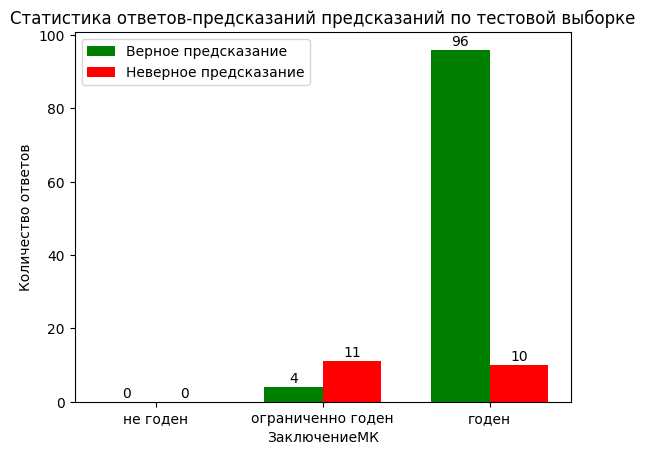

In [415]:
# conclusion_lst = ['не годен', 'ограниченно годен', 'годен']

fig, ax = plt.subplots()

index = np.arange(len(conclusion_lst))
bar_width = 0.35

rects1 = ax.bar(index, arr_true, bar_width, color='g', label='Верное предсказание')
rects2 = ax.bar(index + bar_width, arr_false, bar_width, color='r', label='Неверное предсказание')

ax.set_xlabel('ЗаключениеМК')
ax.set_ylabel('Количество ответов')
ax.set_title('Статистика ответов-предсказаний предсказаний по тестовой выборке')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(conclusion_lst)

ax.legend()

for rect, value in zip(rects1, arr_true):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect, value in zip(rects2, arr_false):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()